# Russian Layout Optimization with Bigrams

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 100
from math import floor
from collections import defaultdict

import colorsys
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Contents

- [How this all works](#hiw)
- [How to test your layout](#how-to-test-your-layout)
- [Initialization and code](#init)
    - [Loading sample texts](#loading-texts)
        - [Some stats on bigrams](#some-stats)
    - [The code with the scoring rules](#scoring-code)
- [Comparing existing and my new layouts](#layouts)
- [Side-to-side comparisons of the best](#side-to-side)
- [Final standings](#standings)
- [Test your layout here](#your-layout)
    - [Compare with others](#compare)
    - [Output statistics in CSV](#output-statistics)
    - [Simple statistics of costs](#simple-stats)
    - [Where do letters want to move?](#letters-move)
    - [Visualizing bigrams in QGIS](#qgis)
- [Is Ergodox better?](#is-ergodox-better)
- [Heatmaps](#heatmaps)


## How This All Works <a name="hiw">

The code is organized in simple to use classes.
    
```
Corpus ------------------------------------------------> | Result
  .bigrams                                        /----> |   .score
                                                 /           .bigrams (w/ scores)
Keyboard ------------------>  Layout -----------/            .layout
  .keymap                       .keyboard                    .corpus
  (fingers & penalties)         .keymap
                                (keys w/ positions)
```

* `Corpus` stores bigrams dataframe, with frequencies and basic info about the letters for categorial analysis.
* `Keyboard` stores a dict: {(row, column): (finger, monogram penalty, ...)}
* To make a new Keyboard, provide it with fingers and penalties strings (see `STANDARD_KBD` and `ERGODOX` below).
* `Layout` takes keyboard, makes the dict a dataframe and adds keys to it.
* `Result` stores score and bigrams costs dataframes.
* `Result` can compare itself with another one, or better call `compare(results_dict, key1, key2)` to do things automatically.

## Testing Your Layout <a name="how-to-test-your-layout">

1. Run the cell with the code to make `CORP` and `STANDARD_KBD` (or another one).
1. Go to [Insert Your Layout](#your-layout) section.
2. Modify the layout, maintaining columns' positions, so that they match `STANDARD_KBD.fingers`.
3. Run the code & see the score.
4. Compare your layout to another one in the cells below that.

# Initialization and Code <a name="init">

In [2]:
# leter categories. V = vowel, C = consonant.
# nb: So-called "soft sign" Ь and "hard sign" Ъ are ancient vowels, and labelled as such.
LT = {'v': 'аеёиоуъыьэюя', 'c': 'бвгджзйклмнпрстфхцчшщ'}

# these keys MUST be in any layout, otherwise the code throws an exception and halts
BASE_KEYS = set('ё-!?%*():;йцукенгшщзхъфывапролджэячсмитьбю.,⌴¶')


class Corpus:
    def __init__(self, bigrams):
        self.bigrams = bigrams
        
    def from_string(raw_text):
        # we take text and encode it, replacing space, linebreak and tab with displayable surrogates.
        # (layouts are encoded with spaces and linebreaks as separators, so this way we won't confuse them)
        text = raw_text.lower().replace(' ', '⌴').replace('\n', '¶').replace('\t', '→')

        nums = defaultdict(int)
        for i in range(2, len(text)):
            nums[text[i-2:i]] += 1

        bigrams = pd.DataFrame(nums.items(), columns=['bigram', 'num'])
        bigrams['l1'] = bigrams.bigram.str[:1]
        bigrams['l2'] = bigrams.bigram.str[1:]
        for i in (1, 2):
            bigrams[f't{i}'] = bigrams[f'l{i}'].map(lambda l: 'v' if l.lower() in LT['v'] else ('c' if l.lower() in LT['c'] else '-'))       
        bigrams['freq'] = bigrams.num / bigrams.num.sum()
        return Corpus(bigrams)
        
    # simple function that reads the corpus and creates a bigram table.
    def from_path(path):
        """Reads file from path and calculates bigrams frequencies."""
        with open(path) as f:
            return Corpus.from_string(f.read())
    
    def display_outerness(self, filter_expr, left_hand=False):
        """Provide a `filter_expr` to filter the bigrams of the corpus,
        and this function will display a table and a plot with
        where a letter is more often in digrams in the subset.

        E.g. English S more often comes first among consonants.
        So it will be on the right (towards right hand pinky)."""
        d2 = self.bigrams[self.bigrams.eval(filter_expr)]
        t2 = d2.groupby('l1').agg({'freq': 'sum'}).join(d2.groupby('l2').agg({'freq': 'sum'}), how='outer', lsuffix='_out', rsuffix='_in')
        t2.fillna(0, inplace=True)
        t2['outer'] = - t2.freq_in + t2.freq_out
        t2['frequency'] = t2.freq_in + t2.freq_out
        t2['outerness'] = t2.outer / t2.frequency
        t2 *= 10000
        title = 'left hand: pinky <-> index' if left_hand else 'right hand: index <-> pinky'
        ax = t2[['frequency', 'outerness']].plot.scatter(x='outerness', y='frequency', title=title)
        for i, r in t2.iterrows():
            ax.annotate(i, (r.outerness + .1, r.frequency + .1))

        return t2.sort_values('outerness') # to readable numbers

## Loading Sample Texts <a name="loading-texts">

This is a sample from Strugatski brothers' "Inhabited Island" and Michail Bulgakov's "White Guard", roughly 500K of characters. Compared to my own texts assembled in 300K chars, some letters differ slightly: letter И (i) is much less popular. I don't know what to do with this.

In [3]:
CORP = Corpus.from_path('../sampletexts.txt')

# Some stats on bigrams <a name="some-stats">

## Vowels outer or inner?

Negative = wants more to be on outer keys, positive = more to inner.

In [4]:
CORP.bigrams

,bigram,num,l1,l2,t1,t2,freq
0,¶м,47,¶,м,-,c,0.000120
1,мо,1366,м,о,c,v,0.003489
2,ож,804,о,ж,v,c,0.002054
3,же,1119,ж,е,c,v,0.002858
4,ет,1997,е,т,v,c,0.005101
...,...,...,...,...,...,...,...
2487,яи,1,я,и,v,v,0.000003
2488,ыу,1,ы,у,v,v,0.000003
2489,?”,1,?,”,-,-,0.000003
2490,.т,1,.,т,-,c,0.000003


In [5]:
CORP.bigrams[(CORP.bigrams.t1 != '-') & (CORP.bigrams.t2 != '-')].groupby('l2').agg({'num': 'sum'}).sort_values('num', ascending=False)


,num
l2,
о,31214
е,23855
а,22927
и,20942
т,19916
н,15269
р,14270
с,11877
л,11081


,freq_out,freq_in,outer,frequency,outerness
ё,0.000000,6.667126,-6.667126,6.667126,-10000.000000
ю,0.434257,38.802165,-38.367908,39.236422,-9778.645833
э,0.025545,2.018019,-1.992475,2.043564,-9750.000000
я,6.156236,54.282160,-48.125924,60.438395,-7962.806424
е,19.516033,106.367489,-86.851456,125.883522,-6899.350649
и,94.821354,33.412266,61.409088,128.233620,4788.844622
о,42.761570,12.951085,29.810485,55.712655,5350.756534
у,17.472469,4.495840,12.976629,21.968309,5906.976744
а,50.808102,10.881977,39.926125,61.690078,6472.049689
ь,7.535641,0.025545,7.510096,7.561186,9932.432432


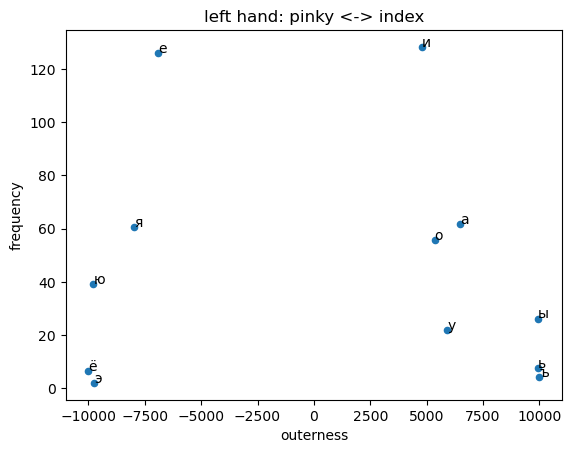

In [6]:
CORP.display_outerness("t1 == 'v' & t2 == 'v'", True)

## Consonants

In my layout, С (s) is the outermost (but in home column), Р (r) and Н (n) are innermost (in home column). Т comes too often before Р (-tr- is frequent like in English), so it isn't on the index finger.

,freq_out,freq_in,outer,frequency,outerness
l1,,,,,
щ,0.332079,7.305740,-6.973661,7.637819,-9130.434783
ц,1.251683,8.480789,-7.229106,9.732472,-7427.821522
л,16.910489,85.957397,-69.046907,102.867886,-6712.192699
р,62.430870,182.285879,-119.855009,244.716749,-4897.703549
н,76.659182,158.146283,-81.487101,234.805466,-3470.409051
т,120.391445,216.490026,-96.098582,336.881471,-2852.593267
ф,3.933860,5.236632,-1.302772,9.170492,-1420.612813
к,55.099585,70.400768,-15.301183,125.500354,-1219.214329
м,24.062962,28.533258,-4.470296,52.596220,-849.927149


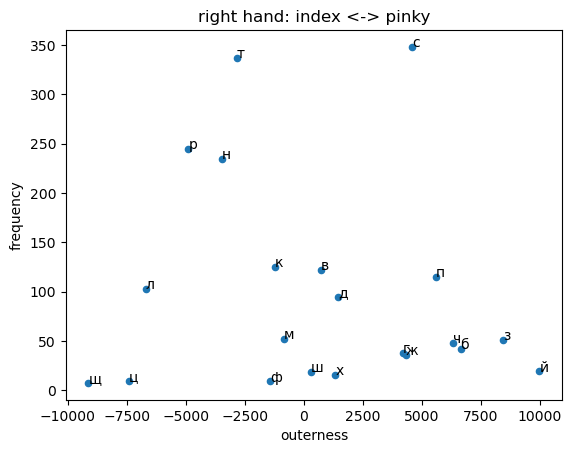

In [7]:
CORP.display_outerness("t1 == 'c' & t2 == 'c'")

Outputting the bigrams to Excel file, to see stats for each letter -- what letters come before it, and what ones come after.

In [8]:
BG = CORP.bigrams
dg2 = BG[BG.l1.isin(BASE_KEYS) & BG.l2.isin(BASE_KEYS)].copy()
dg2['kind_after'] = dg2.t2
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_before', 'prev'], fill_value=0)
dg2['dir'] = 'after'
pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_after', 'next'], fill_value=0)
dg3 = pd1.join(pd2)
dg3

dg3.melt(ignore_index=False).rename(
    columns={'variable_0': 'dir', 'variable_1': 'kind', 'variable_2': 'other', 'value': 'num'}
).reset_index().to_csv('all-letters-melt.csv')

# The Code with The Scoring Rules <a name="scoring-code">

Here we define what fingers press what keys. 0 = left pinky, 9 = right pinky, others in between as you may imagine, left to right.

Spaces & line breaks in beginning of FINGERS/POS_PENALTY are insignificant, but spaces in actual lines with numbers are. These positions must be matched by keyboard descriptions. 

In [9]:
d = {'a': {'id': 1, 'val': 2}, 'b': {'id': 3, 'val': 4}}
pd.DataFrame.from_dict(d, orient='index')

,id,val
a,1,2
b,3,4


In [10]:
STANDARD_FINGERS = '''
001233 6678999
001233 66789999
 01233 6678999
 01233 66789
4
''' 

STANDARD_PENALTIES = '''
753246 6422246
321134 43112357
 00002 2000023
 11114 41111
0
'''

# min(standard, 1) for non-home row
# STANDARD_PENALTIES = """
# 642246 6422246
# 422224 42002246
#  00002 2000024
#  22224 42222
# 0
# """

# standard + 2 everywhere in non-home pos
# STANDARD_PENALTIES = """
# 864468 8644468
# 644446 64224468
#  00004 4000046
#  22226 62224
# 0
# """

In [11]:
def parse_layer(text):
    "Parses text of a layer of layout, fingers or position penalties."
    keys_map = {}
    for ir, row in enumerate(text.lstrip().rstrip().split('\n')):
        for ic, f in enumerate(row):
            if f != ' ' and f != '∅':
                keys_map[(ir, ic)] = f
    return keys_map


def get_finger_props(finger):
    return {
        'finger': finger,  # finger unique ID. (left pinky = 0, left ring = 1, ... right pinky = 9)
        'ftype': floor(abs(4.5 - finger)),  # number in its hand (thumb = 0, pinky = 4)
        'hand': (0 if finger < 4.5 else 1), # hand numebre. Left = 0, right = 1
        'penalty': 0, # position penalty (ie. monogram). From POS_PENALTY
    }

    
KEYCAP_LAYER_SHIFTS = {
    0: (0, 0),
    1: (-.2, .2),
    2: (.2, -.2),
    3: (.5, .6),
    -1: (0, 0)
}


def lighten_color(color, amount=0.5):
    c = colorsys.rgb_to_hls(*matplotlib.colors.to_rgb(color))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


def color_scale(val, min_val, max_val, scale=plt.cm.plasma, lighten=.5):
    return lighten_color(scale((val - min_val) / (max_val - min_val)), lighten)


class Keyboard:
    """Keeps fingers and penalties map of a model or a fingers positioning scheme."""
    def __init__(self, name, fingers, penalties, key_shape=None, extra_keys=None):
        """Creates the instance. Fingers and penalties are strings with lines as rows,
        and line positions of chars as columns. They must match exactly.
        
        Parameters
        ----------
        - name, str: just the name
        - fingers, str: string, where line is row, char pos is column, and the number in there (0..9)
            is the finger. 0 = left pinky, 1 = left ring, .. 9 = right pinky.
            Penalties map and layouts must reproduce these positions.
        - penalties, str: integer penalties in the same positions.
        - key_display, function: a callback that processes a key to be rendered.
            Like adding stagger, depending on row/column.
            Input params: (x: float, y: float, width: float, height: float, keycap: list[str])
            Output: a tuple with the same items.
            This callback won't process `extra_keys`.
        - extra_keys, list: a list of tuples of extra keys to render in the image:
            (x: float, y: float, width: float, height: float, keycap: str).
            Keycap is a single string.

        """
        self.name = name
        self.extra_keys = extra_keys or []
        self.key_shape = key_shape
        self.keymap = {}
        for (ir, ic), f in parse_layer(fingers).items():
            props = get_finger_props(int(f))
            self.keymap[(ir, ic)] = props

        for (ir, ic), p in parse_layer(penalties).items():
            if (ir, ic) not in self.keymap:
                raise ValueError("Penalties map doesn't match fingers map!")
            
            self.keymap[(ir, ic)]['penalty'] = int(p)
    
    def key_coords(self):
        all_keys = []
        for (ir, ic), k in self.keymap.items():
            if self.key_shape:
                x, y, w, h = self.key_shape(ic, ir, 1, 1)
            else:
                x, y, w, h = ic, ir, 1, 1
            
            all_keys.append((ir, ic, x, y, w, h, None))
        
        width = max(i[2] + i[4] for i in all_keys) - min(i[2] for i in all_keys)         
        height = max(i[3] + i[5] for i in all_keys) - min(i[3] for i in all_keys) 
        return all_keys, width, height
        
        
    def raw_display(self, key_caps=None, colors=None, title=None):
        all_keys, width, height = self.key_coords()
        for (x, y, w, h, cap) in self.extra_keys:
            all_keys.append((None, None, x, y, w, h, cap))
        
        fig, ax = plt.subplots(1, 1, figsize=(width, height))
        ax.set_axis_off()
        ax.set_title(title)
        
        font = {'family': 'dejavu sans',
            'color':  '#000',
            'size': 14,
            'linespacing': 1.7,
            'ha': 'center'
        }
        
        max_x = max_y = min_x = min_y = 0
        
        for ir, ic, x, y, w, h, cap in all_keys:
            if cap:
                caps = [cap]
            elif key_caps:
                caps = key_caps.get((ir, ic), [])
            else:
                caps = []
            key_color = colors.get((ir, ic), '#ccc')
                
            y *= -1
            min_x = min(x, min_x)
            min_y = min(y, min_y)
            max_x = max(x + w, max_x)
            max_y = max(y + h, max_y)        

            # we draw the rectangle making a outer margin of 0.2.
            # We just shift the box right-bottom, and make it narrower and lower by 0.4,
            # so that all keys are still referred by key size (1 unit = 20mm),
            # and this is done consistently everywhere.
            ax.add_patch(Rectangle((x + .2, y + .2 - h + 1), w - .4, h - .4,
               color=key_color, ec=key_color, 
               capstyle='round', linewidth=15, linestyle='-', joinstyle='round'))
            
            if key_caps is None:
                continue
            
            if not isinstance(caps, (list, tuple)):
                caps = (caps,)
                
            for layer, cap in enumerate(caps):
                if cap in ('⌴', ' '): continue
                if layer not in KEYCAP_LAYER_SHIFTS:
                    raise ValueError(f'too many layers in key caps: {caps} in keymap')

                dx, dy = KEYCAP_LAYER_SHIFTS[layer]
                
                # same shifting for text
                text_y = y + dy * h + - h / 2 + 1 - .1
                text_x = x + dx * w + w / 2
                
                font_size = 14 if layer == 0 else 10
                plt.text(text_x, text_y, cap, fontdict={
                    **font, 'color':  '#000', 'size': font_size}) # if key.get('c', 0) else '#444444'})
        
        ax.set_xlim(min_x - .25, max_x + .25)
        ax.set_ylim(min_y - .25, max_y + .25)
        
    def display(self):
        """
        Displays the keyboard. Empty or with `key_caps` from a layout.
        
        """
        max_pen = max(k['penalty'] for k in self.keymap.values())
        
        self.raw_display(
            key_caps={coord: [k['penalty']] for coord, k in self.keymap.items()},
            colors={coord: color_scale(k['penalty'], 0, max_pen) for coord, k in self.keymap.items()},
            title = f'{self.name} with monogram penalties'
        )
        

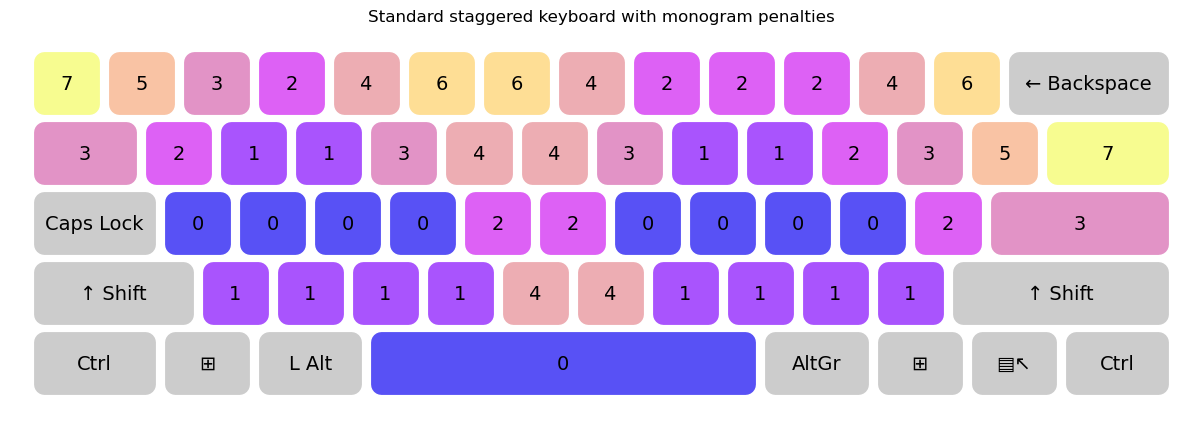

In [12]:
ROW_STAGGER = { 0: 0, 1: .5, 2: .75, 3: 1.25, 4: 1.75 }
                
def std_key_shape(x, y, w, h):
    if x > 6:
        x -= 1


    if x == 0 and y == 1: # '→':
        x -= .5
        w = 1.5
    
    if y == 4: # space bar
        w = 5.25
        x = 2.75
        
    if y == 1 and x == 13: # the / key above the enter
        w = 1.75
    
    if y == 2 and x == 12: # enter
        w = 2.5
        
    if y not in ROW_STAGGER: 
        raise ValueError(f"Row must be 0..=4, got {y} instead.")

    x += ROW_STAGGER[y]

    return x, y, w, h
        
STD_EXTRA_KEYS = [
    (13, 0, 2.25, 1, '← Backspace'),
    
    (0, 2, 1.75, 1, 'Caps Lock'),
    
    (0, 3, 2.25, 1, '↑ Shift'),
    (12.25, 3, 3, 1, '↑ Shift'),

    (0, 4, 1.75, 1, 'Ctrl'),
    (1.75, 4, 1.25, 1, '⊞'),
    (3, 4, 1.5, 1, 'L Alt'),
    (9.75, 4, 1.5, 1, 'AltGr'),
    (11.25, 4, 1.25, 1, '⊞'),
    (12.5, 4, 1.25, 1, '▤↖'),
    (13.75, 4, 1.5, 1, 'Ctrl'),
]
STANDARD_KBD = Keyboard('Standard staggered keyboard', STANDARD_FINGERS, STANDARD_PENALTIES, std_key_shape, STD_EXTRA_KEYS)

STANDARD_KBD.display()

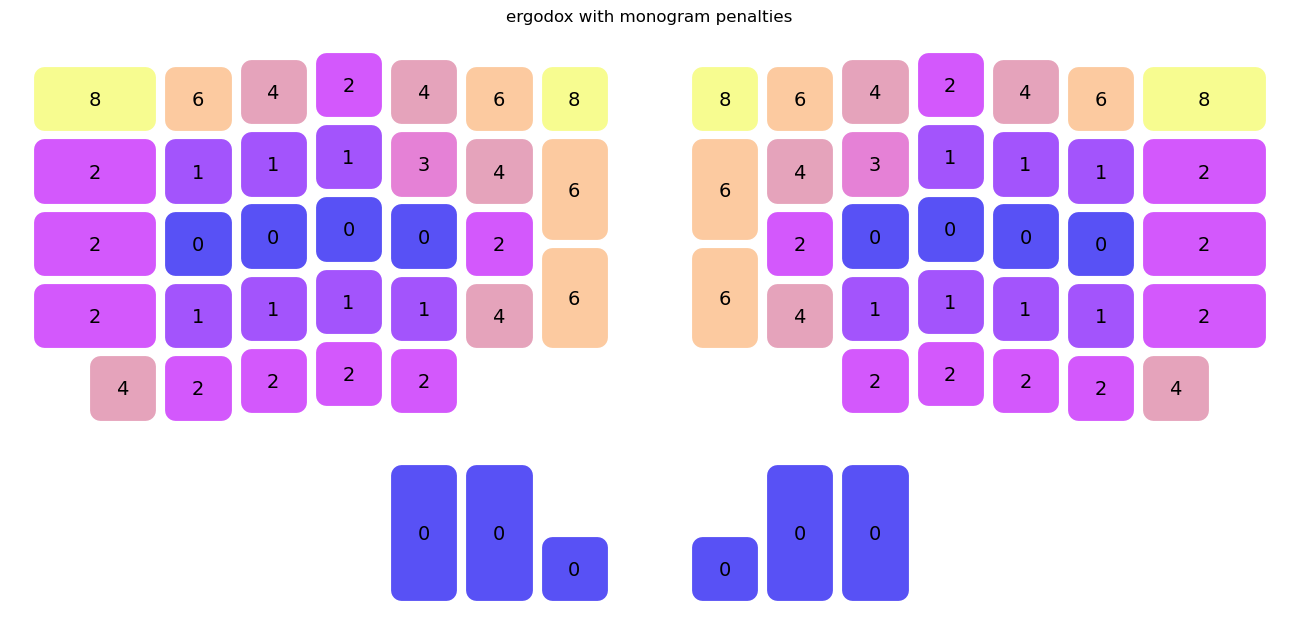

In [13]:
ERGODOX_VSTAG = {2: .1, 3: .2, 4: .1, 10: .1, 11: .2, 12: .1} # x => delta y
def ergodox_key_shape(x, y, w, h):
    if x == 0 and y <= 3:
        w = 1.75
        x -= .75
    
    if x == 14 and y <= 3:
        w = 1.75

    if x in (6, 8) and y in (1, 3):
        h = 1.5
        if y == 3:
            y -= .5

    # thumb blocks
    if y == 5:
        y += .5
        if x in (6, 8):
            y += 1
        else:
            h += 1
    
    # vertical stagger
    if y <= 4:
        y -= ERGODOX_VSTAG.get(x, 0)
    return x, y, w, h
                
        
        
ERGODOX = Keyboard('ergodox',

# note: in the middle columns, there are 2 tall keys, not 3, but I'm not sure how to represent it here,
# so for now, it's set like there are 3.
'''
0012333 6667899
0012333 6667899
001233   667899
0012333 6667899
00123     67899
    444 555
''', # ehm... in reality, I press the outermost keys on the top row with the ring fingers, not pinky, so...
# maybe it's better to write the real usage here...

'''
8642468 8642468
2111346 6431112
200002   200002
2111146 6411112
42222     22224
    000 000
''', ergodox_key_shape)

ERGODOX.display()

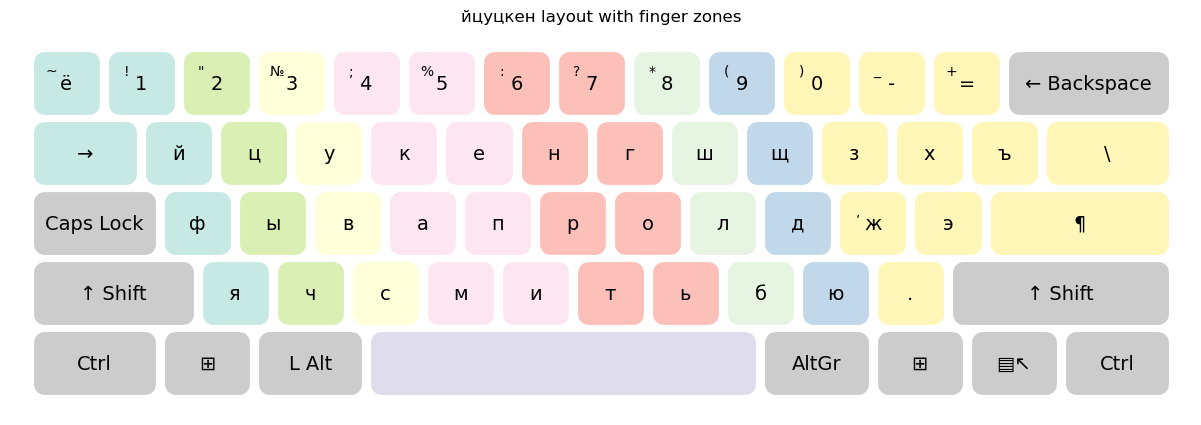

In [14]:
class Layout:
    """Keeps positions of keys on a particular keyboard."""
    def __init__(self, name, layout_config, debug=False):
        """Initialize the layout. `layout_config` must be either text, or 2-tuple (layout text, Keyboard instance)."""

        if isinstance(layout_config, tuple):
            if len(layout_config) != 2:
                raise ValueError(f'Layout must be either a string, or a 2-tuple (layout, keyboard). Got tuple of {len(layout_config)} instead.')
            layout_text, keyboard = layout_config
        else:
            layout_text, keyboard = (layout_config, STANDARD_KBD)

        layers = layout_text.lstrip().rstrip().split('\n\n')
        maps = [parse_layer(l) for l in layers]
        if debug: print('layout', layers)
        keys = ''.join(k for m in maps for k in m.values())
        if debug: print('layout', keys)
        key_counts = defaultdict(int)
        for k in keys:
            key_counts[k] += 1

        for k in set(keys):
            if key_counts[k] > 1 and k not in ('⌴', '¶', '→'):
                print(f'key "{k}" repeated: {key_counts[k]}')

        missing = BASE_KEYS - set(keys)

        if missing:
            raise ValueError(f"Missing keys: {''.join(missing)}, present keys: {''.join(keys)}")

        # making a dict: {letter: (layer, row, column, <finger id>, <finger num in hand>, hand, <pos penalty>)}
        # the last 4 items come from get_finger_props(...) calls
        # make any changes here => change the pd.DataFrame call below
        data = {}
        
        for il, layer in enumerate(maps):
            for (ir, ic), k in layer.items():
                if debug: print(il, ir, ic, k, (ir, ic) in keyboard.keymap)
                if k != '∅' and (ir, ic) in keyboard.keymap:
                    data[k] = {'layer': il, 'row': ir, 'column': ic,
                               'key_count': key_counts[k],
                               **keyboard.keymap[(ir, ic)]}

        self.name = name
        self.keymap = pd.DataFrame.from_dict(data, orient='index')
        self.keyboard = keyboard
        self.original_text = layout_text


    def get_monogram_cost(self, l2):
        """Simply looks up keymap and gets pos_penalty field. Lowercases the letters."""
        
        if l2 not in self.keymap.index:
            if l2.lower() in self.keymap.index:
                l2 = l2.lower() # here we should but don't penalize Shift/AltGr pressing
            else:
                if l2 in BASE_KEYS or l2.lower() in BASE_KEYS:
                    print(l2)
                    print(self.keymap.index)
                    raise ValueError(f'base key \'{l2}\' is not in the layout! (may be caused by unquoted backslash)')
                return 0

        return self.keymap.loc[l2].penalty


    # THE MAIN PENALTIES RULES
    # Here we assign costs and also put a text name for the reason why bigram got it,
    # to quickly see WTF is happening
    def get_bigram_cost(self, bigram):
        l1, l2 = bigram

        if l2 not in self.keymap.index:
            if l2.lower() in self.keymap.index:
                l2 = l2.lower() # lowercase (= no penalties for shifts)
            else:
                return 0, 'L2 not in kbd'
        k2 = self.keymap.loc[l2]

        if l1 not in self.keymap.index:
            if l1.lower() in self.keymap.index:
                l1 = l1.lower() # lowercase of l1.
            else:
                return 0, 'L1 not in kbd'
        k1 = self.keymap.loc[l1]

        rules = (
            (k1.ftype == 0 or k2.ftype == 0, 0, 'space bar'),
            (k1.hand != k2.hand, 0, 'altern hands'),
            (l1 == l2, 0, 'same key'),

            (abs(k2.row - k1.row) >= 2 and k1.ftype == k2.ftype, 8, 'same finger over row'),
            (k1.ftype == k2.ftype, 6, 'same finger adj row'),

            (k1.ftype == 1 and k2.ftype == 4, 2, 'index -> pinky'),

            (abs(k1.ftype - k2.ftype) == 1 and abs(k2.row - k1.row) > 1, 10, 'adj finger over row'),
            (abs(k1.ftype - k2.ftype) == 2 and abs(k2.row - k1.row) > 1, 8, 'over 1 finger, over 1 row'),
            (k1.ftype == 4 and k2.ftype == 1 and abs(k2.row - k1.row) > 1, 4, 'pinky -> index over 1 row'),
            (k1.ftype == 1 and k2.ftype == 4 and abs(k2.row - k1.row) > 1, 6, 'over 2 fingers, over 1 row'),
            
            (k1.ftype > k2.ftype + 1 and k2.row == k1.row, 0, 'in, over 1 finger, same row'),
            (k1.ftype > k2.ftype + 1 and abs(k2.row - k1.row) == 1, 1, 'in, over 1 finger, adj row'),
            (k1.ftype == k2.ftype + 1 and k2.row <= k1.row, 2, 'in, adj finger, same or adj row'),
            (k1.ftype > k2.ftype and k2.row > k1.row, 1, 'in, lower row'),
            
            (k1.ftype == 1 and k2.ftype == 2 and k1.row == k2.row, 1, 'index->middle same row'),
            (k2.ftype > k1.ftype, 4, 'out, over one finger'),
            (k1.ftype + 1 == k2.ftype and k1.row == k2.row, 3, 'out, next finger'),
            (k1.ftype + 1 == k2.ftype and abs(k1.row - k2.row) >= 1, 5, 'out, next finger'),
        )

        for cond, penalty, reason in rules:
            if cond:
                return penalty, reason

        return 4, 'none'

    def keycaps(self):
        keycaps = defaultdict(list)
        for k, r in self.keymap.sort_values('layer').iterrows():
            keycaps[(r['row'], r['column'])].append(k)
        return keycaps

    def display(self):
        """
        Shows the layout with the keyboard.
        """
        
        colors = self.keymap.groupby(['row', 'column']).agg({'finger': 'first'})['finger'].apply(lambda f:
                 lighten_color(plt.cm.Set3((f + (f % 2) * 10) / 20), .5)).to_dict()
        self.keyboard.raw_display(self.keycaps(), colors, f"{self.name} layout with finger zones")

l = Layout('йцуцкен', r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅,
''')
l.display()

# Layouts <a name="layouts">

## Rules:

1. Spaces/linebreaks ARE SIGNIFICANT! (Except at the beginning and end of the whole string -- those are stripped.)
2. Two linebreaks = new level (Shift, AltGr), except for start and end of the whole string.
3. Rows must be in the same order.
4. Letters positions must match those in `FINGERS` and `POS_PENALTY` strings of th keyboard (`STANDARD_KBD` by default).
5. Backslash (`\`) requires Python's raw string syntax: `r''`. Otherwise, duplicate it -- but it creates a lot of confusion with positions.
6. `∅` means no letter at all (or same letter as in lower level). Currently, we don't compute penalties for Shift/AltGr.
7. `¶` means Enter key, and every linebreak in text is treated as hitting this key.
8. `⌴` means space. This is irrelevant for skewed keyboards (they get 0 for any digrams with space), but will be needed for Ergodox.
9. `→` means Tab. Tabs in the text are also scored as keypresses (although in literature corpus they're absent, but if we inserted any text with tables, we'd be able to account for the tab key).
    
## How to test Ergodox and other non-standard models
    
By default, these layouts are used with standard staggered keyboard. If you want Ergodox, then instead of 1 string provide a 2-tuple:
    
```python
    'my_layout': (r'''<the layout>''', ERGODOX),
```
    
If you want different key positions, make a different `Keyboard` instance:
    
```python
    'my_layout': (r'''<the layout>''', Keyboard(<fingers>, <penalties>)),
```
    
search for `леонов` (new finger positions in standard kbd) and `optozorax` (Ergodox) in the dictionary below for examples.

In [15]:
LEONOV_KBD = Keyboard("leonov's remapping", '''
0001233 667899
0001233 667899
 001233 667899
 001233 6678
4
''',

'''
8642226 622246
6421134 431124
 400002 200002
 211114 4111
0
''',
# '''
# 3211113 311123
# 2111112 211112
#  200001 100001
#  111112 2111
# 0
# ''',
#  '''
# 4322224 422234
# 3211123 321123
#  200002 200002
#  211113 3111
# 0
# ''',
         std_key_shape, STD_EXTRA_KEYS
)

In [16]:
layouts = {
    # standard Russian layout ~1890
    'йцукен': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅,
''',

    # QWERTY transliterated ~1970
    'usphonetic': r'''
    
ю12345 67890-ь
→яверт ыуиопшщэ
 асдфг чйкл;'¶
 зхцжб нм,.%
⌴

∅!"ёЁъ Ъ?*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅:"∅
 ∅∅∅∅∅ ∅∅<>?
''',

    # Dvorak transliterated ~2000
    'rusdvorak': r'''
    
ю12345 67890шщ
→',.пы фгцрл/чэ
 аоеуи дхтнс-¶
 ;яйкь бмвжз
⌴

∅!@ё∅ъ %&*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅?∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # "Dictor" layout 200?
    'диктор': r'''
    
ё12345 67890-=
→цья,. звкдчшщъ
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

∅!"№;% ;\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # Zubachov's layout 2007
    'зубачёв': r'''
    
ё12345 67890-=
→фыаяъ ймрпхцщ
 гиеоу лтснзж¶
 шью.э бдвкч
⌴

∅!"№;% :\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅,∅ ∅∅∅∅∅
''',

    # Skoropis 2014 (literally "Fastwrite") from https://cont.ws/@russkivek/93620
    'скоропис': r'''
    
*.ёъ?! ∅-\'()∅
→цья,. звкдчшщ"
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

%12345 67890∅∅
∅∅∅∅;: ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',

    # ANT layout 200?
    # this layout put Ъ's upper and lower case in different places,
    # which my code doesn't understand.
    # had to put the letter on one key to process
    'ант': r'''
    
\!?'"= +-*/%()
→гпрдм ыияухцжч
 внстл ьоеакз¶
 щйшб, .юэёф
⌴

_97531 02468""
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ъ∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅
''',
    
    # UNGVS 2019 https://ubuntu-mate.community/t/make-your-own-custom-keyboard-layout-for-linux/19733/
    'ugnvs': r'''
    
`12345 67890-=
→пдмкз буяьыг:'
 аиеол внтср,¶
 щцэюф хчжйш
⌴

~!?/$% <>*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅;"
 ∅∅∅∅∅ ∅∅∅∅∅.∅
 ∅∅∅∅∅ ∅∅∅∅


∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅ъ∅∅∅∅
 ∅∅ё∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',
    
    # Leonov 2023 https://habr.com/ru/articles/717912/
    # author uses chords for comma and period, here instead they're put in 3rd layer on index fingers.
'леонов': # 
('''
∅123456 7890-=
→щцклбй ъыяэфш
 чзвнтд иаоес¶
 жхпрмг ёьую
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅
 ∅∅∅∅.∅ ∅,∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''',
LEONOV_KBD),
'леонов2': # 
('''
∅123456 7890-=
→чгкблщ ёэыяфш
 цснтрд йиаое¶
 жзпмвх ъюуь
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅,∅ ∅.∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
'леонов3': # 
('''
ъ123456 7890-=
→щчклбй ёыяэфш
 цсвнтд иаоеп¶
 жзхрмг ьую,
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅.
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
    'optozorax': # 2021 https://optozorax.github.io/p/my-keyboard-layout/#russkii-iazyk
    # author never mentions parens in his keyboard definition. I just tossed them wherever there was place.
    ('''
    
+;.:=@∅ ∅*!?#/∅
-йцуеф∅ ∅щгтнз∅
"кмвап   ролджэ
'ячсиы∅ ,шьбюхё
∅∅∅∅∅∅∅ ∅∅∅\∅∅∅
    ∅∅¶ .⌴∅

(75319^ №02468)
_∅∅∅∅∅∅ $∅∅∅∅∅∅
&∅∅∅∅∅   ∅∅∅∅∅∅
|∅∅∅∅∅∅ ∅∅ъ∅∅∅∅
∅∅∅∅∅     ∅%∅∅∅
    ∅∅∅ ∅∅∅
''',
ERGODOX),
    
    'ergodox':  # standard Russian on Ergodox (has troubles with right end of the upper row)
(''' 
ё123456 7890\ъ∅
-йцуке∅ ∅нгшщзх
=фывап   ролджэ
∅ячсми∅ ∅тьбю.∅
∅∅∅∅∅     ∅∅∅∅∅
    ⌴→∅ ∅¶∅

∅!"№;%: ?*()/∅∅
_∅∅∅∅∅∅ ∅∅∅∅∅∅∅
+∅∅∅∅∅   ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅,∅
∅∅∅∅∅     ∅∅∅∅∅
    ∅∅∅ ∅∅∅

''',
ERGODOX),
    
    # my layouts 2021
    'тест1': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фыоап рвлджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест2': r'''
    
ё12345 67890-=
→йцуюк енгбзхъ\
 ыоаия втсрпч¶
 элмдь жшщф.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест3': r'''

ё12345 67890-=
→ъцуюя ьнгбчхй\
 ыоаие втсрпз¶
 эфкмд жшщл.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест4': r'''
    
ё12345 67890-=
→ъэуюя цлнгчхй\
 оаыеи втсрпз¶
 фдьмк жшщб.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест5': r'''
    
ё12345 67890-=
→ъуьюя йлнгчцх\
 оаыеи втсрпз¶
 .фжэд мкшщб
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест6': r'''
    
/12345 67890-=
→ёъьую янвгчйцх
 оиаые лрптсз¶
 ,эфшщ кбмдж
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
   
    'тест7': r'''
    
/12345 67890-=
→ёъьую янджчйцх
 оиаые лрптсз¶
 ,эфшщ вбмкг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест8': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфшщ вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # 2021, the first tested on a real keyboard
  'тест9': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфщш вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # my layouts below: 2024. #10 is the first after manual test
  'тест10': r'''
    
/12345 67890-=
→ёоюэф йнзкдчжц
 ауиея лртпбс¶
 ъыьшщ вмхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест11': r'''
    
/12345 67890-=
→ёоюяф лндкзчжц
 ауиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
''',
  'тест12': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест13': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест14': r'''
    
/12345 67890-=
→ёуюяф лндпзчжц
 аоиеэ вртксб¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест15': r'''
    
/12345 67890-=
→ёуюяф шндпзчжц
 аоиеэ вртксб¶
 щыъьй млхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест16': r'''    
/12345 67890-=
→ёуюяф шндгзчжц
 аоиеэ вртксб¶
 щыъьй млхп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    
'тест17': r'''    
/12345 67890-=
→ёуюяф шндмзчжц
 аоиеэ вртксб¶
 щыъьй хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест18': r'''    
/12345 67890-=
→ьуюяй шндмзчжц
 аоиеэ вртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест19': r'''    
/12345 67890-=
→ьуюяэ шндмвчжц
 аоией зртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест20': r'''    
/12345 67890-=
→ьуюяэ шнмдвчжц
 аоией гртксз¶
 щыъёф хлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест21': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест22': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест23': r'''    
/12345 67890-=
→ъыфхэ шнмвдчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест24': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксб¶
 ьуюяё щ.лпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅,∅∅∅
∅
''', 
'тест25': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксч¶
 ьуюяё щлпб.
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',
    # alien layout experiment #1, with rare letters Ё Щ Ъ on AltGr
    'ино1': r'''    
/12345 67890+
→:ыфхэ цнмвчзж
 аоией ,ртксд¶
 ьуюя- шлбпг
⌴

\!"№∅% ∅?*_()
∅;∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅= ∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅ё∅ ∅∅∅∅∅∅∅
 ъ∅∅∅∅ щ∅∅∅∅
∅
''',

    'тест26': r'''

ъ12345 67890-=
→щфыхё цнмвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    'тест27': r'''

ъ12345 67890-=
→эыфх: цнмвчзжш
 аоией ,ртксд¶
 ьуюяё щлбпг
⌴

\!"№∅% ∅?*()_+
∅∅∅∅∅; ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
    # Alien layout #2, with voiced consonants on AltGr over their voiceless counterparts.
    # e.g. in English B<->P, T (mat) <-> D (mad), K (keel) <-> G (good), V <-> F,
    # Russian has more pairs.
    # same for vowels: compound vowels Я Ю Ё and rare Ё Э are on AltGr,
    # Ы is separated twin of И and also is put there
    
    # This scores great, but abuses the scoring system, because Shift & AltGr aren't penalized
    # In reality, it's hard to hit and release AltGr quickly
    'ино2': r'''

 12345 67890
→-()х: цнмфш+=
 аоией ,ртксч¶
 ьу я! щл п? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅вж∅∅
 ∅ёыэ∅ ∅∅дгз∅∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
'тест28': r'''

ъ12345 67890-=
→щфыхё цмнвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

    'тест29': r'''

ъ12345 67890-=
→щфыхё цмнкчзж/
 аоией ,ртвсд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
  'ино3': r'''

 12345 67890
→-()х: +кмфшщ=
 аоией ,ртнсч¶
 ьу  !  лп ? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅г∅вж∅∅
 яёыэ∅ ∅д∅зц∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
'тест30': r'''

ъ12345 67890-=
→щфыхэ жмвкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест30эрго': 
(r''' 
ъ123456 7890-=/
щжфыхэ∅ ∅цвмкчз
∅аоией   ,ртнсд
∅ьуюяё∅ ∅шлбпг∅
∅∅∅∅∅     ∅∅∅∅∅
    ⌴→∅ ∅¶∅

∅!"№;%: ?*()/∅∅
_∅∅∅∅∅∅ ∅∅∅∅∅∅∅
+∅∅∅∅∅   .∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅     ∅∅∅∅∅
    ∅∅∅ ∅∅∅

''',
ERGODOX),
}

    

In [17]:
layouts2 = {}
for k, definition in layouts.items():
    layouts2[k] = Layout(k, definition)

key "?" repeated: 2
key """ repeated: 2
key ";" repeated: 2
key "." repeated: 2
key ":" repeated: 2
key """ repeated: 3
key ";" repeated: 2
key "." repeated: 2
key "/" repeated: 2


In [18]:
class Result:
    # Gets the cost for input KBD text, bigrams & fingers maps
    def __init__(self, corpus, layout):
        bigram_df = corpus.bigrams.copy()

        # taking the text of keyboard layout and encode it into keymap a dataframe
        bigram_df['price_l2'] = bigram_df.l2.apply(layout.get_monogram_cost) 

        # calculate bigrams cost
        bigram_df[['price_di', 'category']] = bigram_df.bigram.apply(lambda d: pd.Series(layout.get_bigram_cost(d)))
        bigram_df['price'] = bigram_df.price_l2 + bigram_df.price_di
        bigram_df['cost'] = bigram_df.price * bigram_df.num
        bigram_df['finger'] = bigram_df['l2'].map(layout.keymap.finger)
        bigram_df['column'] = bigram_df['l2'].map(layout.keymap.column)
        bigram_df['row'] = bigram_df['l2'].map(layout.keymap.row)
        self.bigrams = bigram_df
        self.corpus = corpus # it's not copied here, just a pointer
        self.layout = layout # also not copied
        self.score = bigram_df.cost.sum() / bigram_df.num.sum()

    def compare(self, other):
        x = self.bigrams[['bigram', 'num', 'category', 'price', 'cost']].merge(
            other.bigrams[['bigram', 'category', 'price', 'cost']],
            on='bigram', suffixes=['_old', '_new'])
        x['delta'] = x['cost_new'] - x['cost_old']
        return x[x.delta != 0].sort_values('delta', ascending=False)

    def display(self, what='costs'):
        show_costs = what in ('cost', 'costs')
        show_nums = what in ('freq', 'frequencies', 'num', 'nums')
        
        if show_costs:
            df = self.bigrams.groupby(['row', 'column']).agg({'cost': 'sum', 'num': 'sum'})
            df['meancost'] = df['cost'] / df['num']
            
            min_cost = df['meancost'].min()
            max_cost = df['meancost'].max()
            
            colors = df['meancost'].apply(color_scale, args=(min_cost, max_cost)).to_dict()
            self.layout.keyboard.raw_display(
                df['meancost'].round(2).to_dict(), colors, f'{self.layout.name} costs (on 2nd keys of bigrams)')
            
        elif show_nums:
            nums = self.bigrams.groupby(['row', 'column']).agg({'num': 'sum'}).round(0)['num']
            min_num = nums.min()
            max_num = nums.max()
            colors = nums.apply(color_scale, args=(min_num, max_num))
            self.layout.keyboard.raw_display(
                nums.to_dict(), colors.to_dict(), f'{self.layout.name} frequencies (on 2nd keys of bigrams)')
            
        else:
            raise ValueError('what must be \`cost\` or \`freq\`.')
    
    def combodata(self):
        filtered = self.bigrams[(self.bigrams.l2 != '⌴') & (self.bigrams.l1 != '⌴')].copy()
        l1 = filtered.rename(columns={'l1': 'l'})[['l', 'cost', 'num']]
        l2 = filtered.rename(columns={'l2': 'l'})[['l', 'cost', 'num']]
        ll = pd.concat([l1, l2]).groupby('l').agg({'cost': 'sum', 'num': 'sum'})
        ll = ll.merge(self.layout.keymap[['layer', 'row', 'column']], left_index=True, right_index=True
                 ).reset_index(names='letter').groupby(['layer', 'row', 'column']
                 ).agg({'cost': 'sum', 'num': 'sum', 'letter': 'first'})

        ll['price'] = ll.cost / ll.num
        return ll
        
    def combomap(self, other):     
        layouts = [(i, i.layout.keyboard.key_coords(), i.combodata()) for i in (self, other)]
        width = max(i[1][1] for i in layouts)
        all_heights = sum(i[1][2] for i in layouts) + 1
        fig, axes = plt.subplots(2, 1, figsize=(width, all_heights))

        ll = pd.concat([i[2] for i in layouts])
        max_cost = ll['cost'].max() ** .5
        max_num = ll['num'].max() ** .5
        max_price = ll['price'].max()
        min_price = ll['price'].min()

        plt.text(width / 2, all_heights / 2 + .5, 'Layouts comparison. Size = key\'s bigrams cost. Color = mean price. Scales are the same.',
             size=14, ha='center')

        for (result, (all_coords, width, height), ll), ax in zip(layouts, axes):
            ll2 = ll.reset_index().groupby(['row', 'column']).agg({'cost': 'sum', 'num': 'sum', 'letter': 'sum'})
            ll2['price'] = ll2['cost'] / ll2['num']
            ax.set_xlim(0, width)
            ax.set_ylim(0, height)
            ax.set_axis_off()
            ax.set_title(f'{result.layout.name}')
            keycaps = result.layout.keycaps()

            for ir, ic, x, y, w, h, _ in all_coords:
                if (ir, ic) not in ll2.index: continue
                
                vals = ll2.loc[(ir, ic)]
                cost = vals['cost'] ** .5
                num = vals['num'] ** .5
                price = vals['price']
                color = color_scale(price, min_price, max_price, plt.cm.viridis, lighten=.6)

                ax.add_patch(plt.Circle((x, height - y - .5), cost / max_cost / 1.5, color=color))

                if (ir, ic) not in keycaps: continue
                cap = keycaps[(ir, ic)]
                ax.text(x, height - y - .55, cap[0].replace('⌴', ''),
                     fontdict={'color':  '#000', 'size': 12, 'ha': 'center'})
                
    def combochart(self, other):
        self_ll = self.combodata()
        other_ll = other.combodata()
        ll2 = self_ll.merge(other_ll, on='letter', how='outer', suffixes=['1', '2'])
        ax = ll2.plot.scatter(x='num1', y='cost1', figsize=(10, 6), s=50)
        for i, r in ll2.iterrows():
            ax.annotate(r['letter'].replace('¶', '\\n'), (r['num1'] + 1000, r['cost1']))
        ll2.plot.scatter(x='num2', y='cost2', ax=ax, color='#c44')
        for i, r in ll2.iterrows():
            ax.annotate(r['letter'].replace('¶', '\\n'), (r['num2'] + 1000, r['cost2']))
        ax.set_title(f'Comparison of {self.layout.name} (blue) and {other.layout.name} (red)')


def compare(results_dict, key1, key2):
    return results_dict[key1].compare(results_dict[key2])

In [19]:
results = {}

for k, lyt in layouts2.items():
    print(f'layout {k}: ', end='')
    results[k] = r = Result(CORP, lyt)
    print(round(r.score, 4))

layout йцукен: 3.0119
layout usphonetic: 2.9405
layout rusdvorak: 1.5727
layout диктор: 1.3489
layout зубачёв: 1.3092
layout скоропис: 1.3433
layout ант: 1.6093
layout ugnvs: 1.8154
layout леонов: 1.2387
layout леонов2: 1.0565
layout леонов3: 1.2787
layout optozorax: 2.093
layout ergodox: 2.9561
layout тест1: 2.7209
layout тест2: 2.1991
layout тест3: 1.9594
layout тест4: 1.7151
layout тест5: 1.5857
layout тест6: 1.5559
layout тест7: 1.5657
layout тест8: 1.5568
layout тест9: 1.5619
layout тест10: 1.4365
layout тест11: 1.464
layout тест12: 1.3934
layout тест13: 1.3943
layout тест14: 1.334
layout тест15: 1.2645
layout тест16: 1.2555
layout тест17: 1.211
layout тест18: 1.2249
layout тест19: 1.2283
layout тест20: 1.2259
layout тест21: 1.1821
layout тест22: 1.1821
layout тест23: 1.1719
layout тест24: 1.1676
layout тест25: 1.1784
layout ино1: 1.1049
layout тест26: 1.1436
layout тест27: 1.1313
layout ино2: 0.9034
layout тест28: 1.1072
layout тест29: 1.0953
layout ино3: 0.9126
layout тест30: 1.

# Side-to-side comparison of the two best layouts  <a name='side-to-side'>

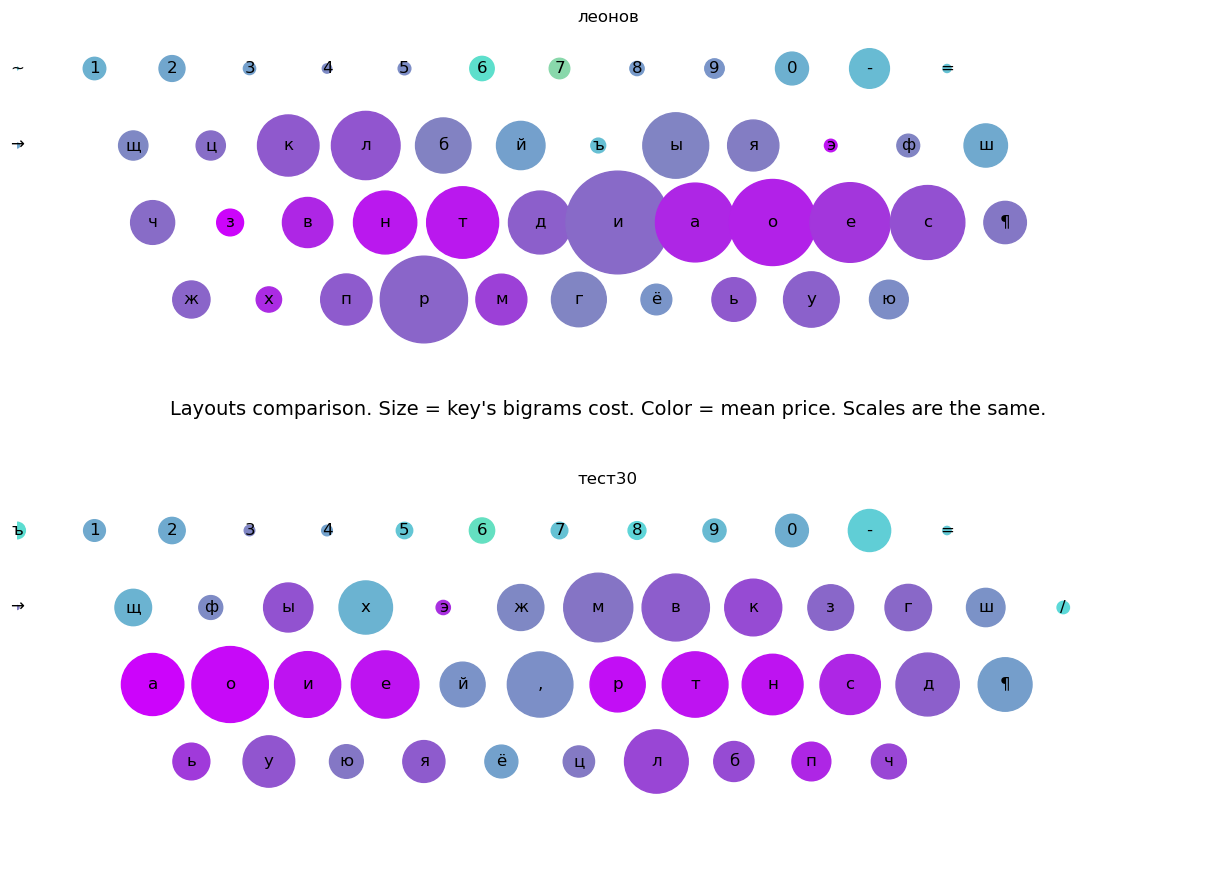

In [49]:
results['леонов'].combomap(results['тест30'])

In [21]:
b = CORP.bigrams
b[(b.l1 == 'в') | (b.l2 == 'в')].sort_values('num', ascending=False)

,bigram,num,l1,l2,t1,t2,freq
18,⌴в,4955,⌴,в,-,c,0.012657
35,ов,3193,о,в,v,c,0.008156
63,в⌴,3020,в,⌴,c,-,0.007714
36,ва,2240,в,а,c,v,0.005722
50,во,1937,в,о,c,v,0.004948
286,ве,1311,в,е,c,v,0.003349
42,ав,1074,а,в,v,c,0.002743
112,вы,1020,в,ы,c,v,0.002606
49,тв,926,т,в,c,c,0.002365
43,ви,876,в,и,c,v,0.002238


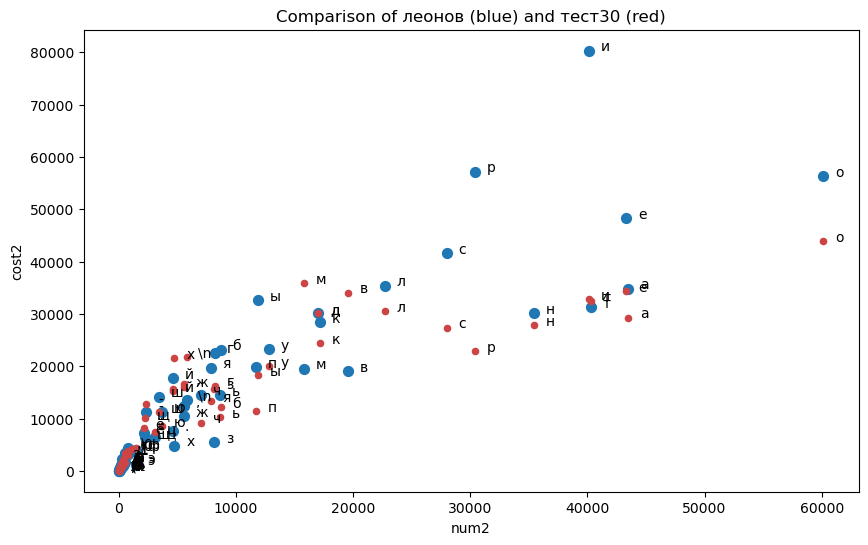

In [22]:
results['леонов'].combochart(results['тест30'])

# Final Standings <a name="standings">

In [23]:
print('Standard keyboard league:\n')
chosen_kbd = [
    ('йцукен', 'Default Russian kbd'),
    ('usphonetic', 'QWERTY transit'),
    ('rusdvorak', 'Dvorak translit'),
    ('диктор', 'Dictor'),
    ('зубачёв', 'Zubachov'),
    ('скоропис', 'Skoropis'),
    ('ант', 'ANT'),
    ('ugnvs', 'UGNVS'),
    ('леонов', 'Leonov'),
    ('тест1', 'Def.Rus with couple of letters swapped'),
    ('тест2', 'My first Dvorak analog'),
    ('тест9', 'First hand-tested'),
    ('тест10', 'First optimized after hand testing'),
    ('ино1', 'Alien #1, rare letters on AltGr'),
    ('тест30', 'Best and currently in use on my laptop'),
    ('ино2', 'Alien #2, many counterparts on AltGr'),
]
print(
    pd.DataFrame([(k, results[k].score.round(3), d) for k, d in chosen_kbd],
        columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
    .to_markdown(index=False)
)

print('\nErgodox league:\n')
chosen_kbd = [
    ('optozorax', 'ErgoDox Moonlander, alien'),
    ('ergodox', 'Stardand Russian on Ergodox'),
    ('тест30эрго', 'My best layout minimally adapted to Ergodox'),
]
print(
    pd.DataFrame([(k, results[k].score.round(3), d) for k, d in chosen_kbd],
        columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
    .to_markdown(index=False)
)

# how well I am against Leonov's layout (the best of eariler authors' layouts)
round(1 - results['тест30'].score / results['леонов'].score, 3)

Standard keyboard league:

| layout     |   score | comment                                |
|:-----------|--------:|:---------------------------------------|
| ино2       |   0.903 | Alien #2, many counterparts on AltGr   |
| тест30     |   1.093 | Best and currently in use on my laptop |
| ино1       |   1.105 | Alien #1, rare letters on AltGr        |
| леонов     |   1.239 | Leonov                                 |
| зубачёв    |   1.309 | Zubachov                               |
| скоропис   |   1.343 | Skoropis                               |
| диктор     |   1.349 | Dictor                                 |
| тест10     |   1.437 | First optimized after hand testing     |
| тест9      |   1.562 | First hand-tested                      |
| rusdvorak  |   1.573 | Dvorak translit                        |
| ант        |   1.609 | ANT                                    |
| ugnvs      |   1.815 | UGNVS                                  |
| тест2      |   2.199 | My first Dvorak analog  

0.118

# Test Your Layout Here <a name="your-layout">
    
To measure this for a different keyboard, or different fingers positions, add Keyboard instance:
```python
'my_layout': (r'''
<layout definition>
''', Keyboard('my_special_kbd', ''' 
000123 6789999
001233 66789999
 01233 66789999
 01233 667899
4
''', '''
432111 1111234
210012 21001123
 00001 10000123
 00002 200001
0
'''))
```

To the results above: the Test27 layout seems very good, and I use it to type in Russian sometimes, but there's still some awkwardness to it. And it actually has much disbalance to the right hand. It's 20% more loaded and gets 80% more penalties.

IDK if I made something useful or just abuse my own scoring system.

In [24]:
lyt = Layout('тест31', r'''

ъ12345 67890-=
→ьуюяё жшвкчзщ
 аоией ,ртнсд¶
 пфыхэ цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''')


results[lyt.name] = r = Result(CORP, lyt)
print(lyt.name, ':', round(r.score, 3), '')

тест31 : 1.091 


In [25]:
real_kbd = Keyboard('real fingers', ''' 
000012 3678999
000123 66789999
 01233 6678999
 01233 667899
4
''', '''
864222 4222468
622123 43112246
 00002 2000024
 11114 411112
0
''',
std_key_shape, STD_EXTRA_KEYS)

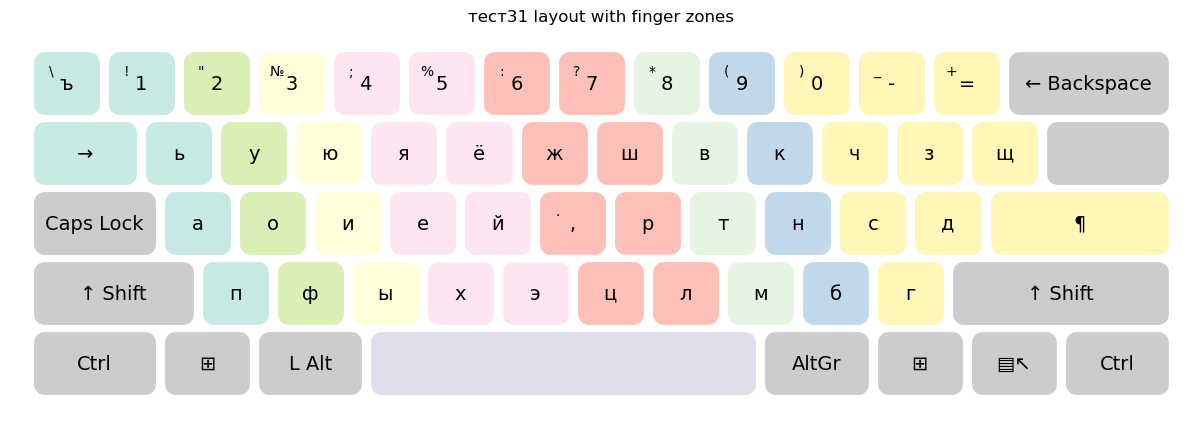

In [26]:
lyt.display()

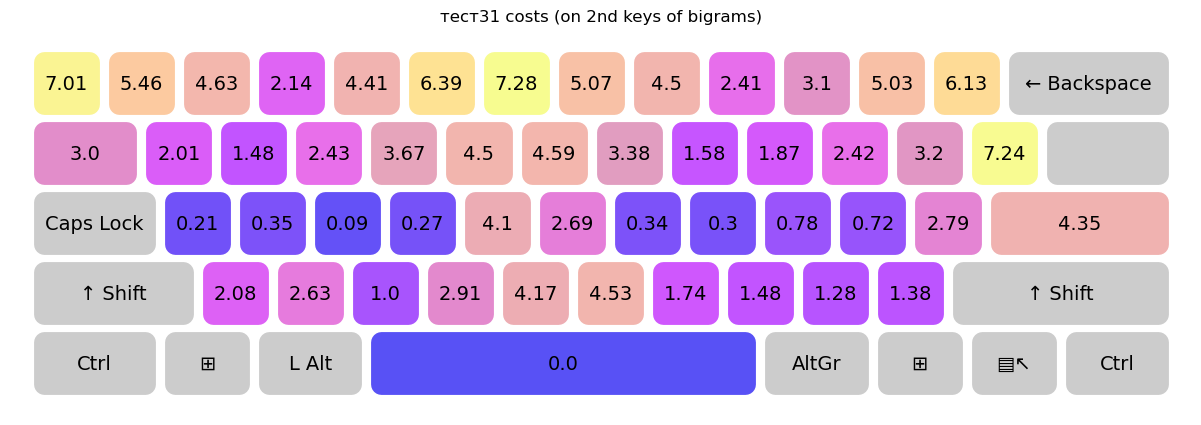

In [27]:
r.display('cost')

## Compare with others <a name="compare">

See what has changed, what bigrams degraded, and what were benefitial.

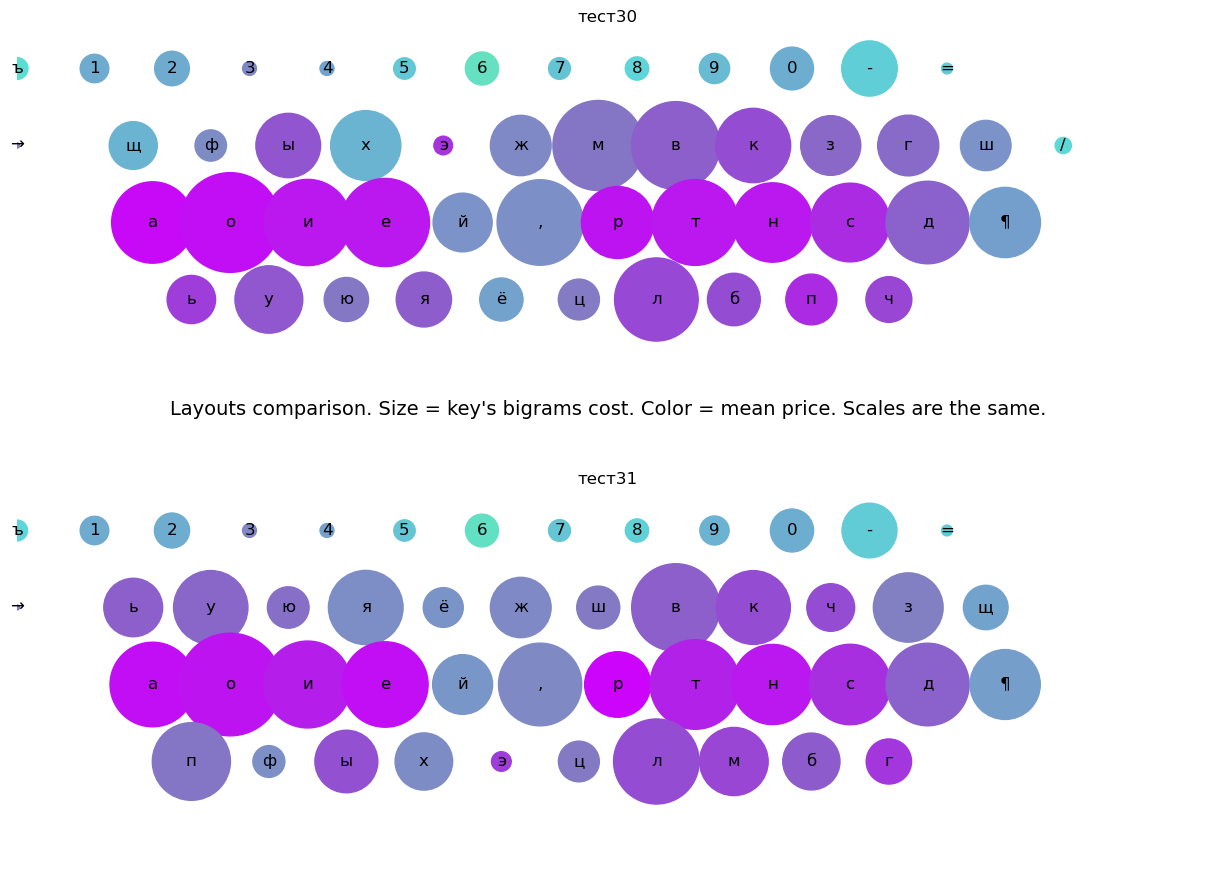

In [28]:
results['тест30'].combomap(results['тест31'])

## Losses

In [29]:
compare(results, 'тест30', 'тест31').head(30)

,bigram,num,category_old,price_old,cost_old,category_new,price_new,cost_new,delta
55,по,3115,altern hands,0,0,"in, adj finger, same or adj row",2,6230,6230
159,уп,357,altern hands,1,357,adj finger over row,11,3927,3570
262,ия,1139,"in, lower row",2,2278,"in, adj finger, same or adj row",5,5695,3417
188,бщ,231,altern hands,2,462,adj finger over row,15,3465,3003
303,па,477,altern hands,0,0,same finger adj row,6,2862,2862
38,ть,2493,altern hands,1,2493,altern hands,2,4986,2493
436,пу,248,altern hands,1,248,adj finger over row,11,2728,2480
131,ся,1192,altern hands,1,1192,altern hands,3,3576,2384
295,оп,568,altern hands,1,568,"out, over one finger",5,2840,2272
46,ль,2056,altern hands,1,2056,altern hands,2,4112,2056


## Gains

In [30]:
compare(results, 'тест30', 'тест31').tail(30)

,bigram,num,category_old,price_old,cost_old,category_new,price_new,cost_new,delta
351,вп,57,adj finger over row,11,627,altern hands,1,57,-570
611,щё,151,pinky -> index over 1 row,8,1208,altern hands,4,604,-604
140,уг,306,altern hands,3,918,altern hands,1,306,-612
302,сп,628,"in, lower row",2,1256,altern hands,1,628,-628
424,м.,158,same finger adj row,8,1264,"in, adj finger, same or adj row",4,632,-632
408,чш,66,same finger over row,13,858,"in, over 1 finger, same row",3,198,-660
430,ьш,341,altern hands,5,1705,altern hands,3,1023,-682
624,чк,91,adj finger over row,11,1001,"in, adj finger, same or adj row",3,273,-728
223,мп,94,"over 1 finger, over 1 row",9,846,altern hands,1,94,-752
402,⌴х,376,space bar,3,1128,space bar,1,376,-752


You can save comparison table to CSV:

In [31]:
compare(results, 'леонов', 'тест30').to_csv('leonov-test30.csv')

## Simple Statistics, What Cost The Most <a name="simple-stats">

In [32]:
results['тест30'].bigrams.sort_values('cost', ascending=False).head(30) #.to_csv('/tmp/test26.csv')

,bigram,num,l1,l2,t1,t2,freq,price_l2,price_di,category,price,cost,finger,column,row
25,⌴м,2178,⌴,м,-,c,0.005564,3,0,space bar,3,6534,6.0,8.0,1.0
49,тв,926,т,в,c,c,0.002365,1,6,same finger adj row,7,6482,7.0,9.0,1.0
296,ей,790,е,й,v,c,0.002018,2,6,same finger adj row,8,6320,3.0,5.0,2.0
40,⌴п,5662,⌴,п,-,c,0.014463,1,0,space bar,1,5662,8.0,10.0,3.0
177,.¶,1085,.,¶,-,-,0.002772,3,2,index -> pinky,5,5425,9.0,13.0,2.0
191,ом,1719,о,м,v,c,0.004391,3,0,altern hands,3,5157,6.0,8.0,1.0
227,⌴д,2489,⌴,д,-,c,0.006358,2,0,space bar,2,4978,9.0,12.0,2.0
18,⌴в,4955,⌴,в,-,c,0.012657,1,0,space bar,1,4955,7.0,9.0,1.0
195,од,2317,о,д,v,c,0.005919,2,0,altern hands,2,4634,9.0,12.0,2.0
153,ог,1500,о,г,v,c,0.003832,3,0,altern hands,3,4500,9.0,12.0,1.0


## Statistics of Bigrams to CSV <a name="output-statistics">

We count how often a key comes before or after which one. We add categories to simplify statistics analysis: vowel/consonant/other, hand (in layout 27), row, column. 

In [33]:
key = 'тест29' # the output file will be 'all-letters-melt-<key>.csv'
res = results[key]


BG = CORP.bigrams
km = res.layout.keymap
dg2 = BG[BG.l1.isin(BASE_KEYS) & BG.l2.isin(BASE_KEYS)].copy()
dg2['kind_after'] = dg2.t2
dg2['row1'] = dg2.l1.map(km['row'])
dg2['row2'] = dg2.l2.map(km['row'])
dg2['hand1'] = dg2.l1.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['hand2'] = dg2.l2.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['hand'] = dg2.hand1
dg2['row'] = dg2.row1
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}
        ).pivot_table('num', 'letter', ['dir', 'kind_before', 'hand', 'row', 'prev'], fill_value=0)

dg2['dir'] = 'after'
dg2['hand'] = dg2.hand2
dg2['row'] = dg2.row2

pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}
                ).pivot_table('num', 'letter', ['dir', 'kind_after', 'hand', 'row', 'next'], fill_value=0)
dg3 = pd1.join(pd2) #.reset_index()

dg3.melt(ignore_index=False).reset_index().rename(
    columns={'variable_0': 'where', 'variable_1': 'ftype', 'variable_4': 'other', 
             'variable_2': 'hand', 'variable_3': 'row', 'value': 'num',
            'letter': 'letter'}).to_csv(f'all-letters-melt-{key}.csv')

## Check the keymap (for errors) <a name="keymap">

In [34]:
lyt.keymap
# or 
# results['тест28'][1]

,layer,row,column,key_count,finger,ftype,hand,penalty
ъ,0,0,0,1,0,4,0,7
1,0,0,1,1,0,4,0,5
2,0,0,2,1,1,3,0,3
3,0,0,3,1,2,2,0,2
4,0,0,4,1,3,1,0,4
5,0,0,5,1,3,1,0,6
6,0,0,7,1,6,1,1,6
7,0,0,8,1,6,1,1,4
8,0,0,9,1,7,2,1,2
9,0,0,10,1,8,3,1,2


# Where do letters want to move? <a name="letters-move">
    
TODO

## Visualizing Frequencies in QGIS <a name="qgis">

In [35]:
letters = results['тест29'].bigrams[['column', 'row', 'l2', 'num']].groupby(['column', 'row', 'l2']).agg({'num': 'sum'}).reset_index()
letters['WKT'] = 'POINT(' + letters['column'].astype(str) + ' ' + (4 - letters['row']).astype(str) + ')'
letters.to_csv('letters-freq.csv')

# Ergodox League <a name="ergodox">

Let's compare the standard layout on Ergodox with Optozorax' one.
    
The first test here showed that I got finger numbers wrong in `ERGODOX`, that's why this is also helpful.

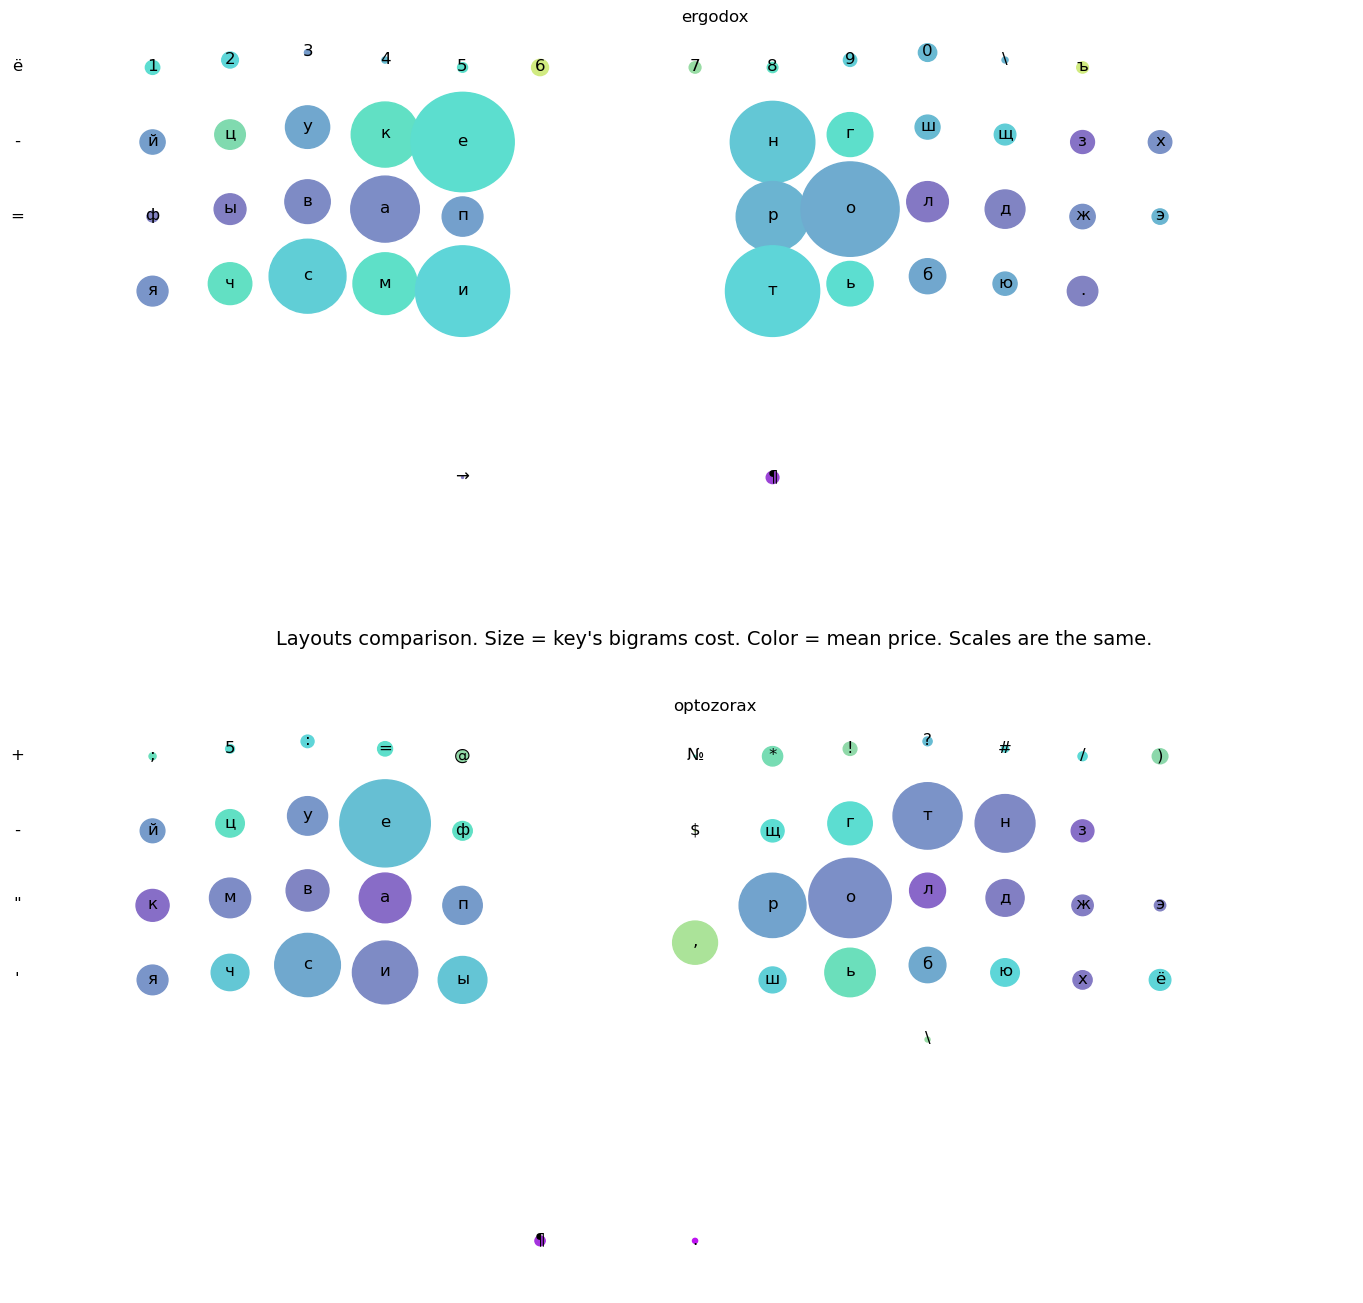

In [36]:
results['ergodox'].combomap(results['optozorax'])

As we can see in the map above, йцукен on Ergodox is harder in most keys. Let's see what letters were improved actually:

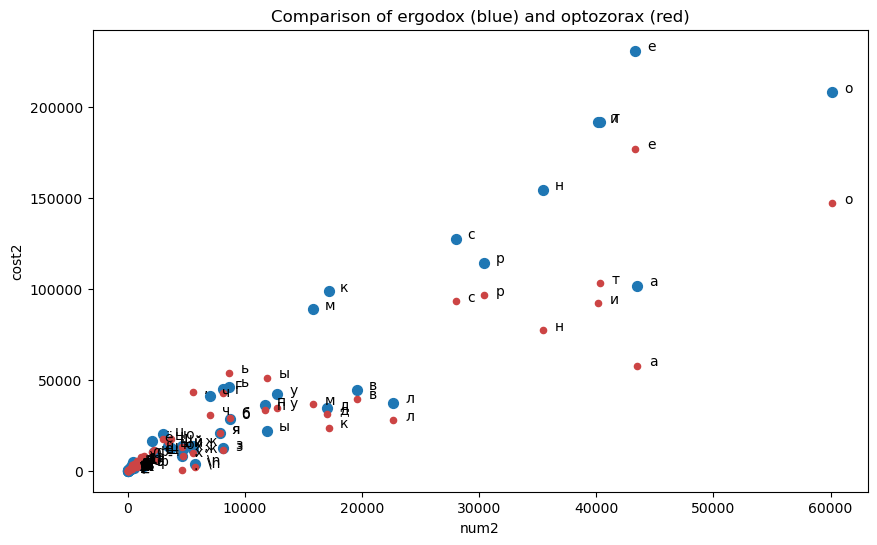

In [37]:
results['ergodox'].combochart(results['optozorax'])

But you may notice that Optozorax' layout is actually a modest modification of the standard ЙЦУКЕН. How far can we improve it? I've simply translated my test28, moving the rightmost letter Ж to the left side, and slash to up-right corner. The result scores 2.5 times better.

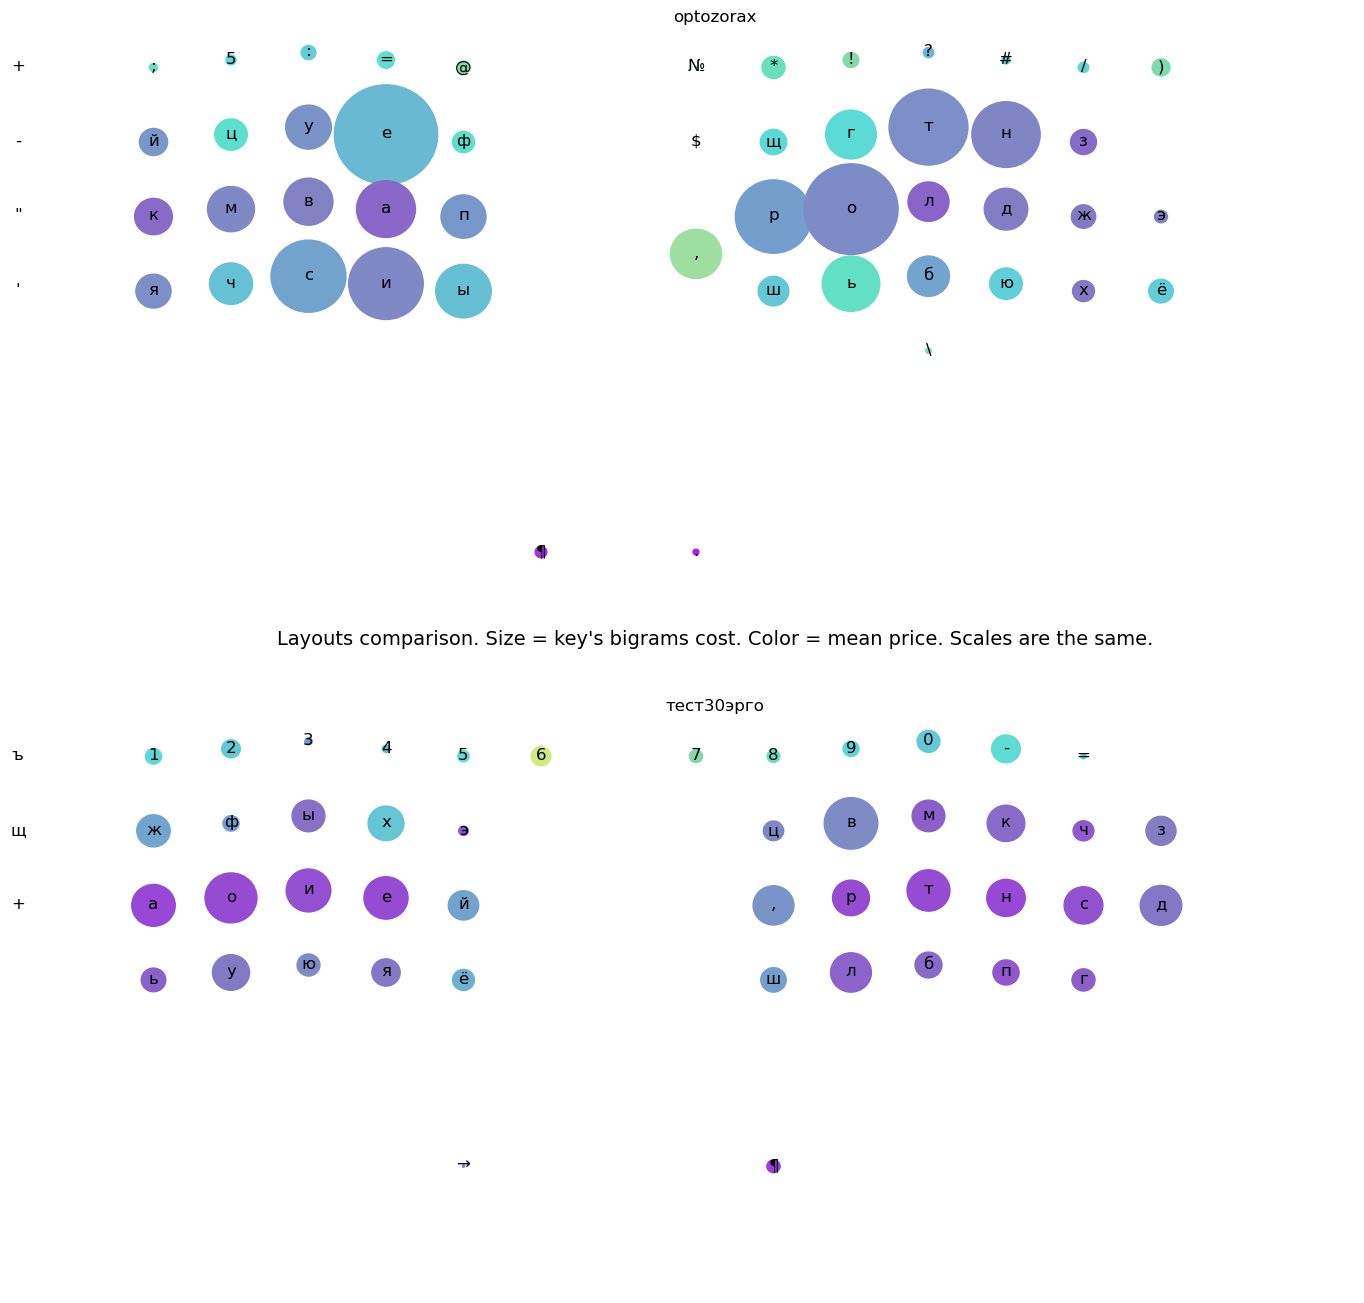

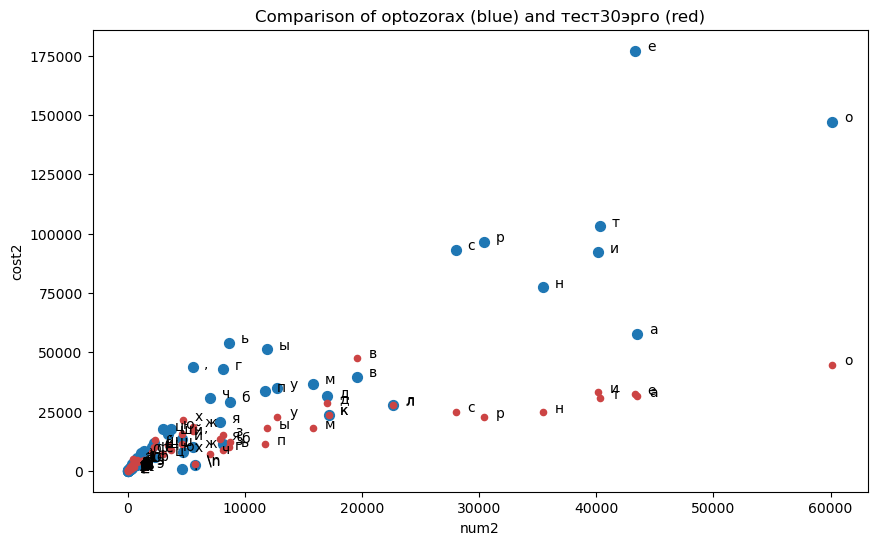

In [39]:
results['optozorax'].combomap(results['тест30эрго'])
results['optozorax'].combochart(results['тест30эрго'])

# Heatmaps <a name="heatmaps">

To see the heatmap by just number of key presses, use `pivot_table('num'`, to see the one for penalties, use `pivot_table('cost'`.

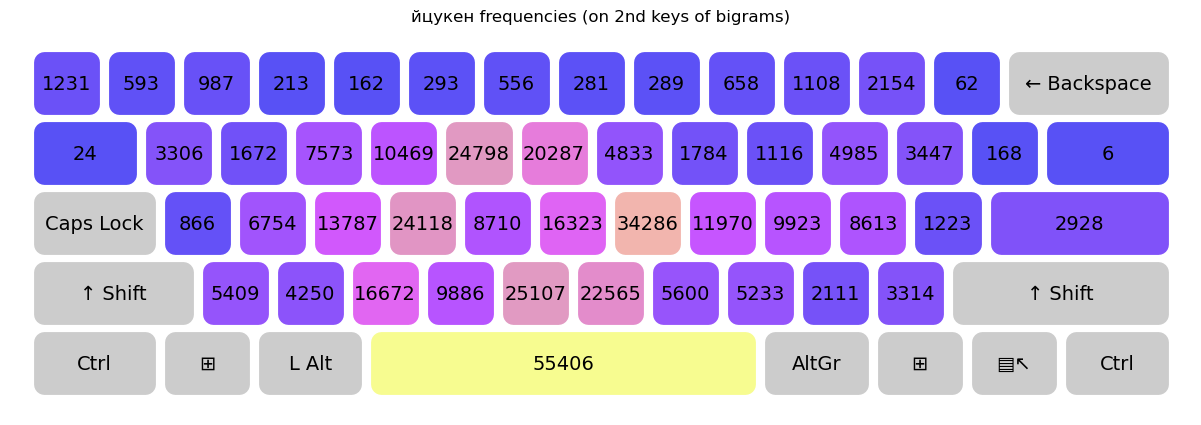

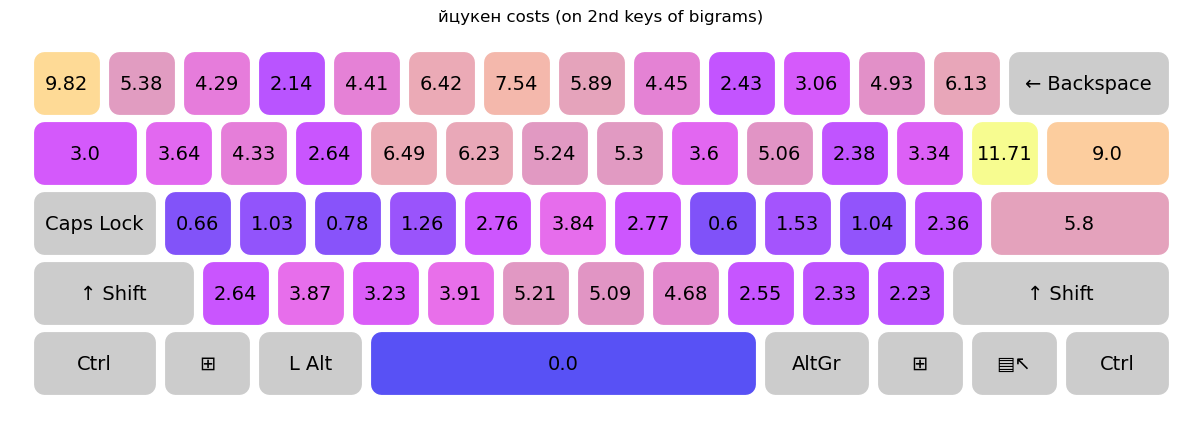

In [40]:
results['йцукен'].display('num')
results['йцукен'].display('cost')

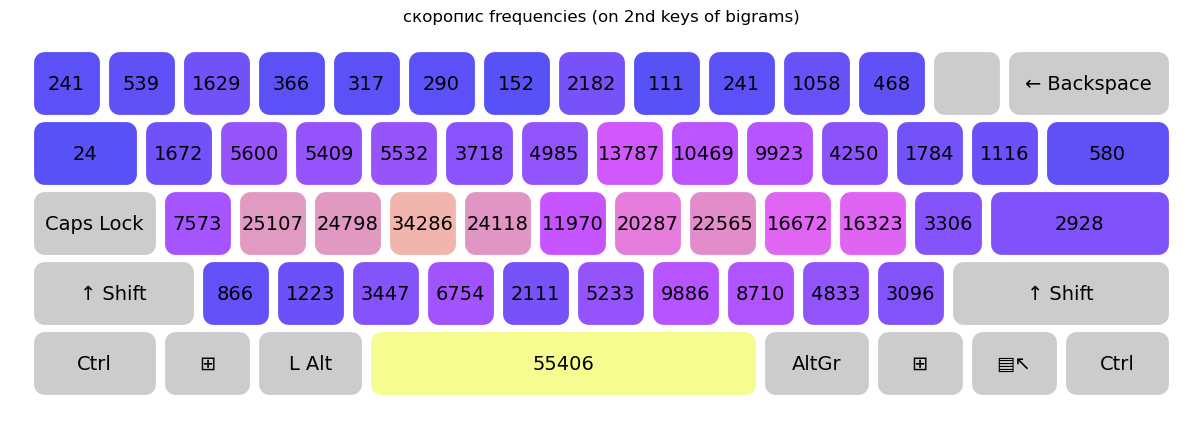

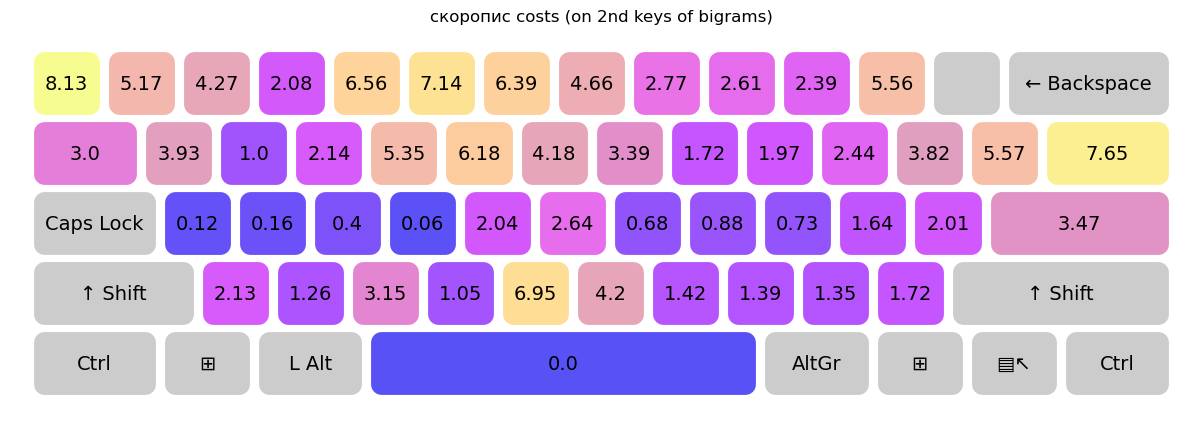

In [41]:
results['скоропис'].display('num')
results['скоропис'].display('cost')

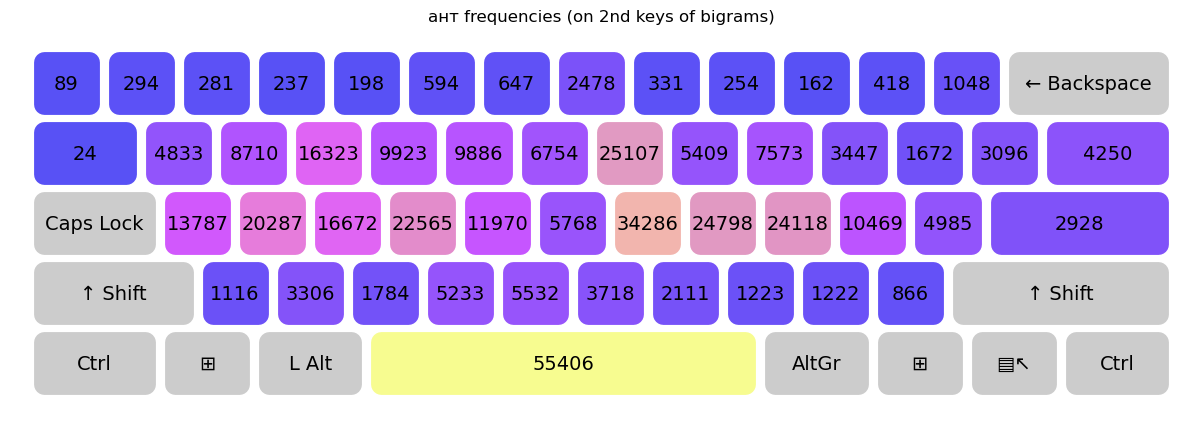

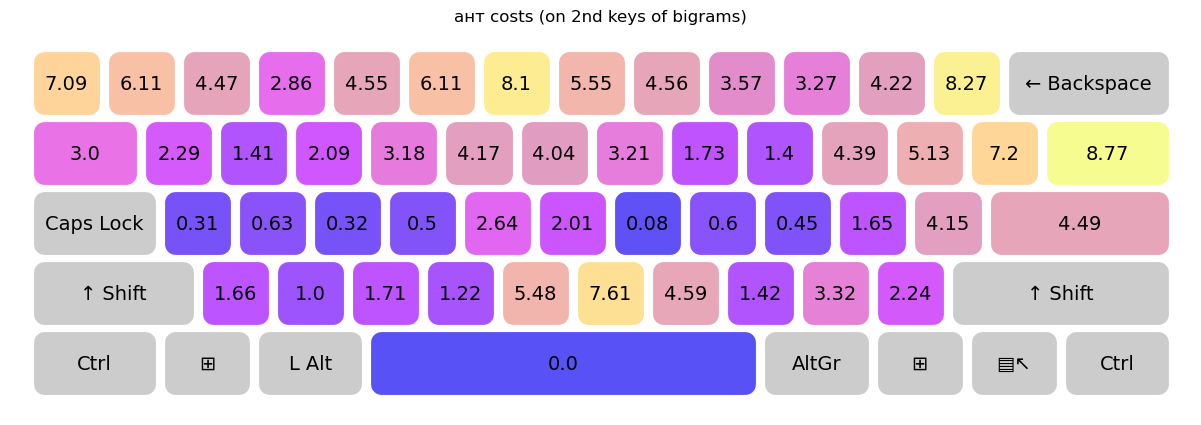

In [42]:
results['ант'].display('num')
results['ант'].display('cost')

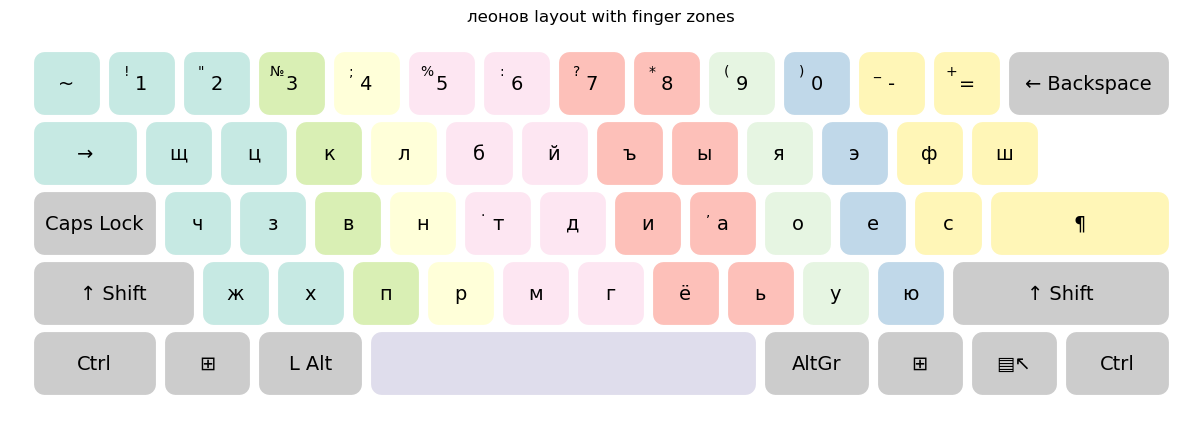

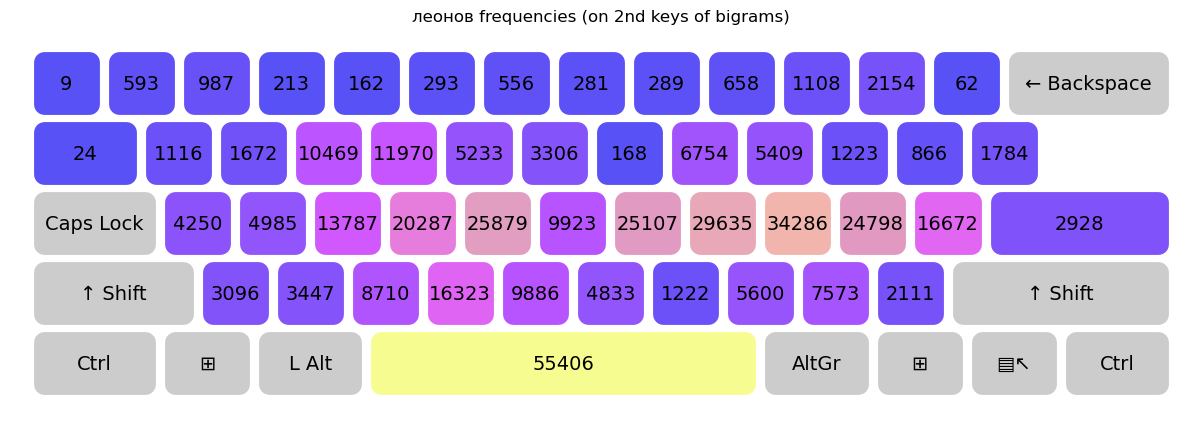

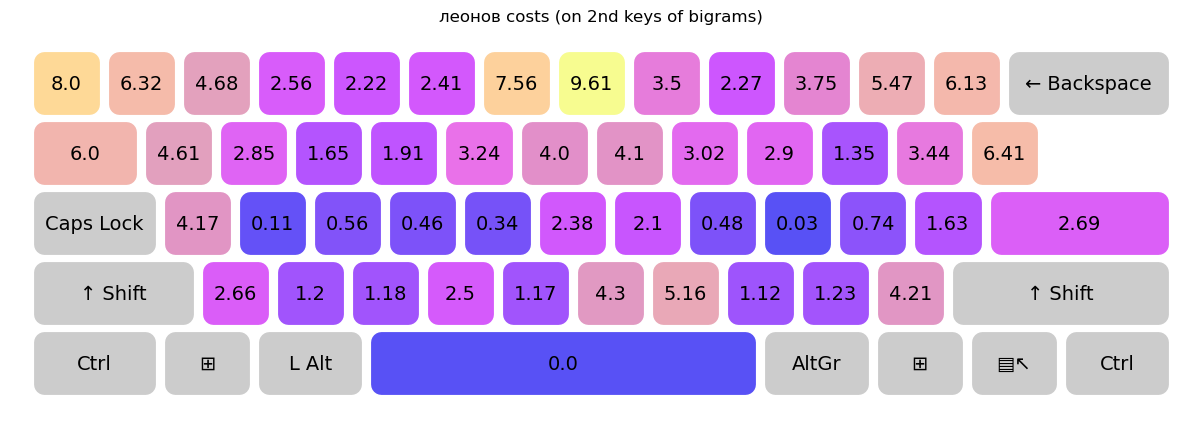

In [43]:
results['леонов'].layout.display()
results['леонов'].display('num')
results['леонов'].display('cost')

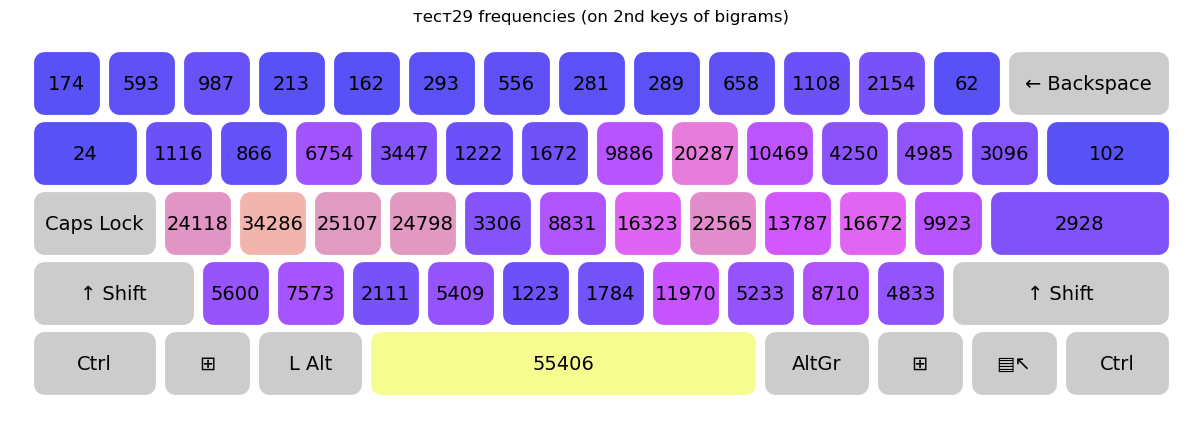

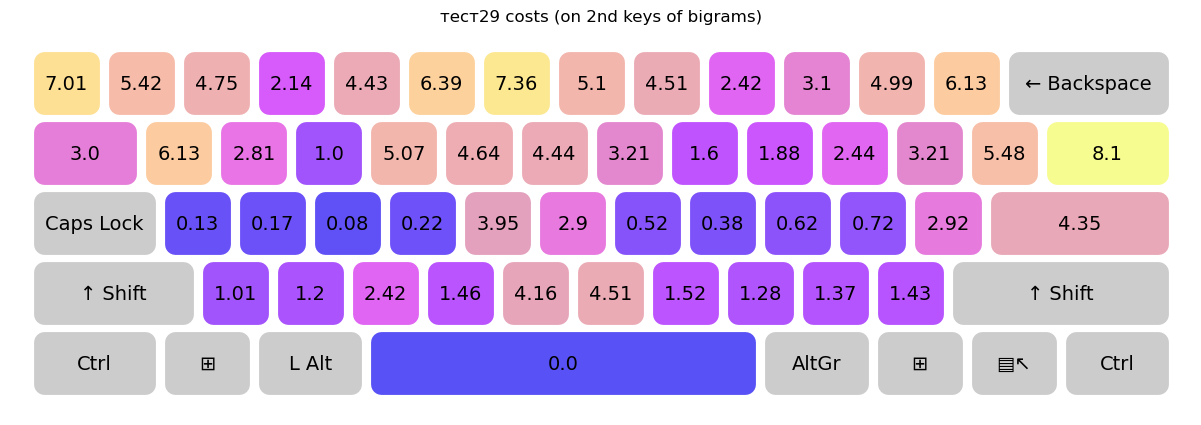

In [44]:
results['тест29'].display('num')
results['тест29'].display('cost')

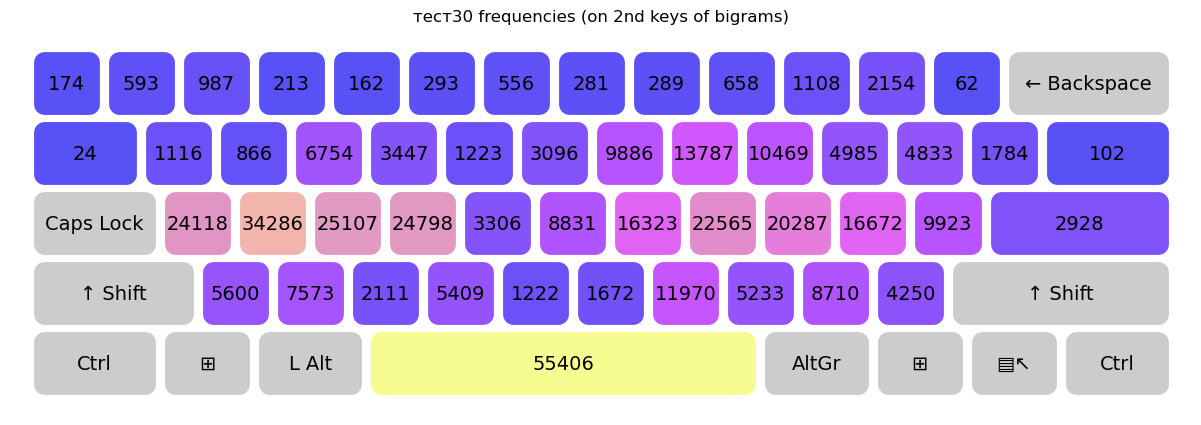

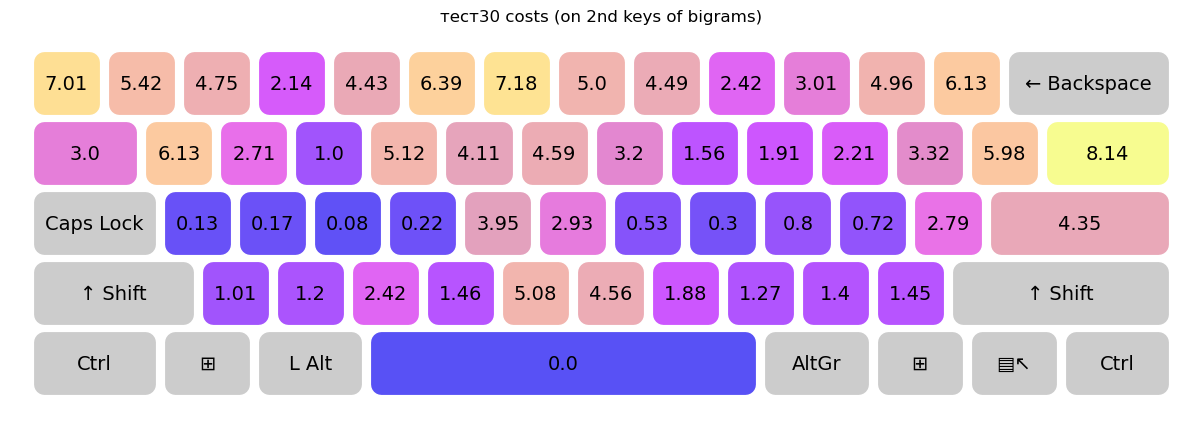

In [45]:
results['тест30'].display('num')
results['тест30'].display('cost')

# Comparison of best others' and mine

In [46]:
r = compare(results, 'леонов', 'тест29')
r.head(30)

,bigram,num,category_old,price_old,cost_old,category_new,price_new,cost_new,delta
66,⌴н,4755,space bar,0,0,space bar,1,4755,4755
25,⌴м,2178,space bar,1,2178,space bar,3,6534,4356
94,⌴з,1384,space bar,0,0,space bar,3,4152,4152
130,тс,879,altern hands,0,0,"out, over one finger",4,3516,3516
191,ом,1719,altern hands,1,1719,altern hands,3,5157,3438
71,ых,829,altern hands,1,829,"in, adj finger, same or adj row",5,4145,3316
116,аз,1101,altern hands,0,0,altern hands,3,3303,3303
14,тн,547,index->middle same row,1,547,same finger adj row,7,3829,3282
177,.¶,1085,altern hands,2,2170,index -> pinky,5,5425,3255
296,ей,790,altern hands,4,3160,same finger adj row,8,6320,3160


In [47]:
r.tail(30)

,bigram,num,category_old,price_old,cost_old,category_new,price_new,cost_new,delta
491,гл,227,adj finger over row,11,2497,"in, over 1 finger, same row",1,227,-2270
129,ае,572,"out, over one finger",4,2288,"in, over 1 finger, same row",0,0,-2288
181,ой,1149,altern hands,4,4596,"in, over 1 finger, same row",2,2298,-2298
155,ие,1197,"out, over one finger",4,4788,"in, adj finger, same or adj row",2,2394,-2394
110,ки,1228,altern hands,2,2456,altern hands,0,0,-2456
147,ми,1241,altern hands,2,2482,altern hands,0,0,-2482
156,ис,1273,index -> pinky,2,2546,altern hands,0,0,-2546
69,ор,2584,altern hands,1,2584,altern hands,0,0,-2584
184,ое,665,"out, over one finger",4,2660,"in, over 1 finger, same row",0,0,-2660
324,бр,308,adj finger over row,11,3388,"in, adj finger, same or adj row",2,616,-2772


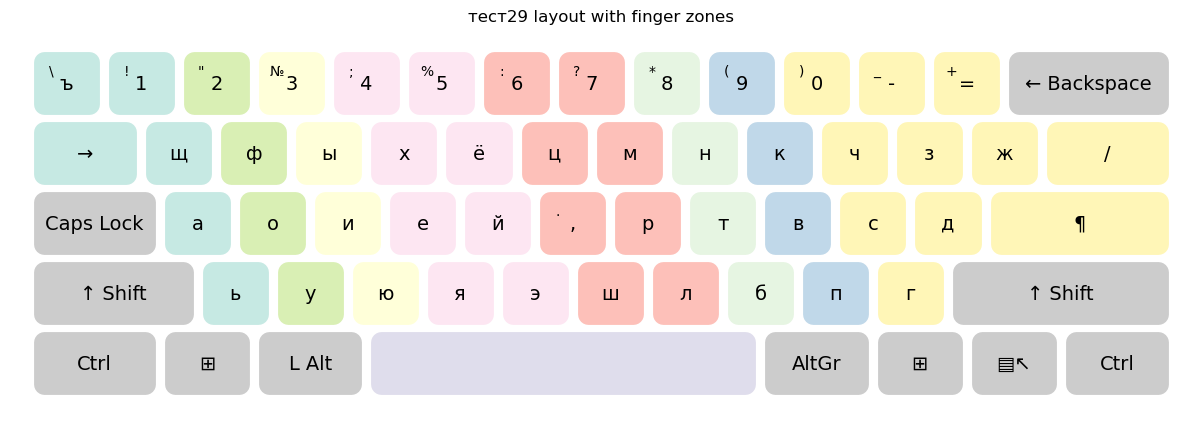

In [48]:
results['тест29'].layout.display()